# Tank Level Forecasting Model Comparison

Code to compare and visualize forecast model accuracy based on RMSE and Computational Complexity.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Comparison utility functions

In [2]:
# define global forecast evaluation threshold for all models
# only consider actual vs. forecast RMSE for actual tank levels equal or greater than this value
flt_thrsh = 25

# function to convert csv into a dict of forecast dfs for plotting or other
def forecastcsv_to_dfs(file, device_ids):  
    # parse csv file of forecasts by device into a dict of dfs

    # import dataset
    df = pd.read_csv(file, parse_dates=['TSTAMP'])

    # create a dict of dataframes subsetted by the DEVICE_ID to separate each device for analysis
    # (using deep copy to eliminate pointer to referenced df)
    df_forecasts = {}

    for ii in device_ids:
        # subset into a df per device
        df_forecasts[ii] = df[(df['DEVICE_ID'] == ii)].copy()
        # set index of each df to TSTAMP and sort ascending
        df_forecasts[ii] = df_forecasts[ii].set_index('TSTAMP').sort_index() 
        
    return df_forecasts
 
# function to plot comparison of tank level actual vs. forecast values
def plot_forecasts_by_device(forecastdf_dict, device_ids_list, threshold_col, actual_cols, forecast_cols, model_name, flt_thrsh=0):
    
    for ii in device_ids_list:
        # take a copy of the dataframe
        df = forecastdf_dict[ii].copy()
        
        # create a series that is a boolean filter of actual values less than threshold
        filt_thresh = df[threshold_col] < flt_thrsh
        
        # set forecast values to nan where the actual value is less than threshold
        df.loc[filt_thresh, forecast_cols] = np.nan
                       
        ( df[actual_cols + forecast_cols]
         .plot(title = f'Device{ii} {model_name} Model Tank Level Actual vs. Forecasted by Period', 
               ylim=(0,100), figsize = (16,4)) )        

# function to create a df of mean rmse across models
def df_model_rmse_comparison(df, pcols):
    agged_series = df[pcols].mean().sort_values(ascending=True)
    df_agged = agged_series.to_frame(name='RMSE')
    df_agged.index.name = 'Model'
    return(df_agged)
        
# function to plot model rsme results
def plot_model_rmse_comparison(df, pcols, pname):

     # create barplots by device and rate column
    fig, ax = plt.subplots(figsize=(8, 12))

    # transform and plot df
    df = df[pcols].mean().sort_values(ascending=False)
    df.plot.barh(rot=0, width= 0.25, ax=ax, xlim=(0,50))

    # apply RMSE labels to each bar
    for i, v in enumerate(df.values):
        ax.text(v + 2, i, str(round(v,2)))    

    # title
    ax.set_title(f'Forecast Model Tank Level RMSE Comparison for {pname} Period Forecasts')
    ax.set_xlabel('Mean RMSE (Tank Level %)')
       

## Load model results datasets

In [3]:
# load results datasets
device_base_model_rmse_df = pd.read_csv('data/base_model_results_alldevices.csv', header=0, index_col=0)
device_exp_model_rmse_df = pd.read_csv('data/ets_model_results_alldevices.csv', header=0, index_col=0)
device_arima_model_rmse_df = pd.read_csv('data/AutoARIMA_model_results_alldevices.csv', header=0, index_col=0)
device_arimaexog_model_rmse_df = pd.read_csv('data/AutoARIMAExog_model_results_alldevices.csv', header=0, index_col=0)
device_lstm_model_rmse_df = pd.read_csv('data/lstm_model_results_alldevices.csv', header=0, index_col=0)
device_lstmTemp_model_rmse_df = pd.read_csv('data/lstmTemp_model_results_alldevices.csv', header=0, index_col=0)


Ideal device data includes Devices 3 and 6.


In [4]:
# concat all results into a single dataframe for 'all' devices
dfs = [device_base_model_rmse_df, device_exp_model_rmse_df, device_arima_model_rmse_df, 
       device_arimaexog_model_rmse_df, device_lstm_model_rmse_df, device_lstmTemp_model_rmse_df]

allmodels_rmse_df = pd.concat(dfs, axis=1)

# create dataframe of 'ideal' devices
allmodels_ideal_rmse_df = allmodels_rmse_df.loc[['device3', 'device6']]


In [5]:
# create list of model columns by period
suffix = ['_1P', '_6P', '_12P', '_36P', '_72P', '_144P', '_288']

period_cols = [allmodels_rmse_df.filter(like=suffix[ii]).columns for ii in range(len(suffix))]


## Model Computational Complexity

In [6]:
# load results datasets
device_base_model_process_time_df = pd.read_csv('data/base_model_process_time_alldevices.csv', header=0, index_col=0)
device_exp_model_process_time_df = pd.read_csv('data/ets_model_process_time_alldevices.csv', header=0, index_col=0)
device_arima_model_process_time_df = pd.read_csv('data/AutoARIMA_model_process_time_alldevices.csv', header=0, index_col=0)
device_arimaexog_model_process_time_df = pd.read_csv('data/AutoARIMAExog_model_process_time_alldevices.csv', header=0, index_col=0)
device_lstm_model_process_time_df = pd.read_csv('data/lstm_model_process_time_alldevices.csv', header=0, index_col=0)
device_lstmTemp_model_process_time_df = pd.read_csv('data/lstmTemp_model_process_time_alldevices.csv', header=0, index_col=0)

In [7]:
# concat all results into a single dataframe
dfs = [device_base_model_process_time_df, device_exp_model_process_time_df, device_arima_model_process_time_df, 
       device_arimaexog_model_process_time_df, device_lstm_model_process_time_df, device_lstmTemp_model_process_time_df]

allmodels_process_time_df = pd.concat(dfs, axis=1)

Sum model computational time across devices (seconds)

In [8]:
allmodels_process_time_df.sum().sort_values()

Naive                          0.407833
MovingAvg72                    0.409047
MovingAvg144                   0.417831
RunningAvg                     0.464736
Drift6                         0.613364
Drift12                        0.614264
Drift1                         0.620484
Drift1_mean30                  1.047421
Drift6_mean30                  1.076500
Drift12_mean30                 1.084802
ets72AautoNN                 228.683543
ets144AautoNN                237.045908
ets72AautoAautoN             329.983766
ets144AautoAautoN            338.941527
ets72AautoAautoDautoN        363.913071
lstm                         375.869226
lstmTemp                     376.952956
ets144AautoAautoDautoN       387.567148
etsfullAautoNN               708.270386
etsfullAautoAautoN          1725.346689
etsfullAautoAautoDautoN     2369.115026
AutoARIMA                  18814.175004
AutoARIMAExog              19765.682297
dtype: float64

Scale model computational complexity to relative to the naive model.

In [9]:
naive_time = allmodels_process_time_df.sum().loc['Naive']

model_computation_scaled = allmodels_process_time_df.sum().div(naive_time).sort_values()


In [10]:
# display results in a dataframe
df_scaled = model_computation_scaled.to_frame(name='Computational Complexity (CC)')

df_scaled.index.name = "Model"

df_scaled.style.format("{:.2f}")



## 1 Period Forecasts Model Comparison

### Across all device conditions

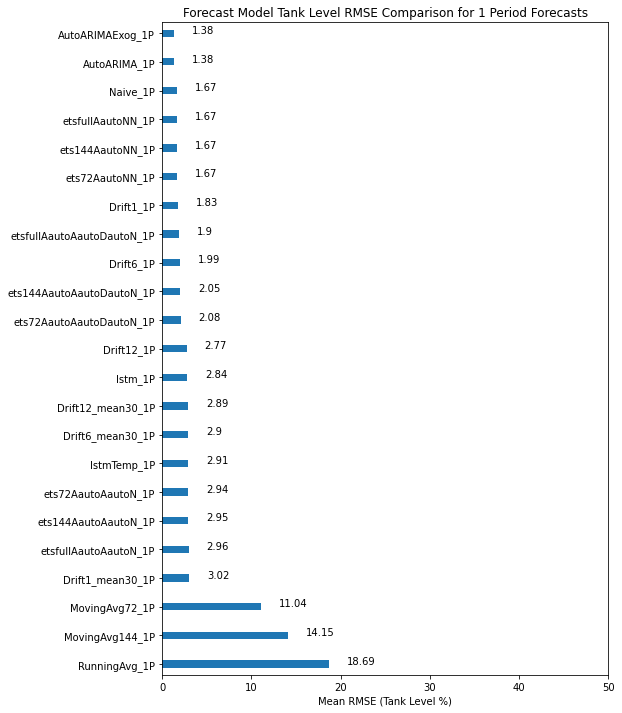

In [11]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[0], pname='1')


In [12]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[0])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")


### Across ideal device conditions

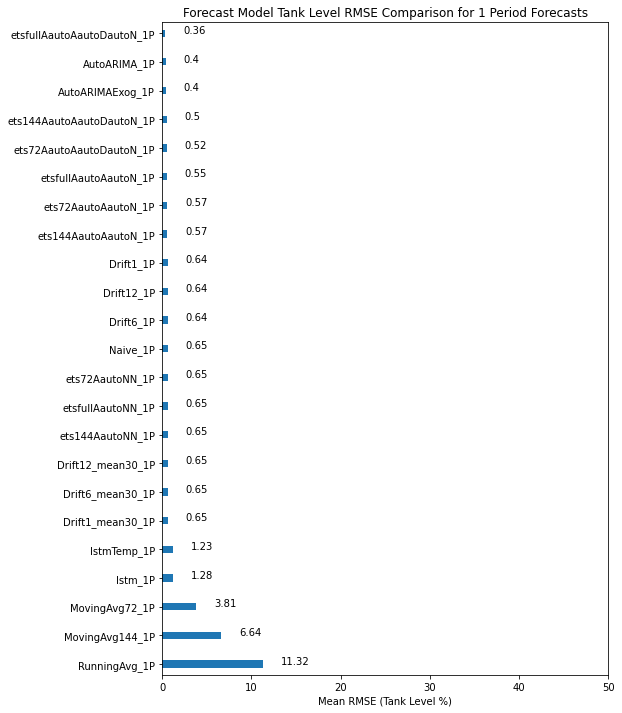

In [13]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[0], pname='1')

In [14]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[0])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")



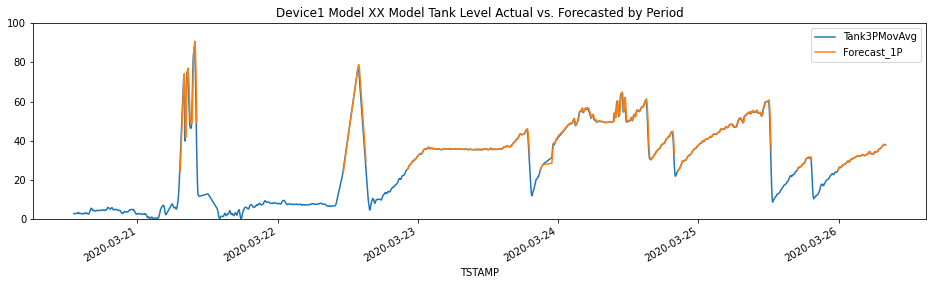

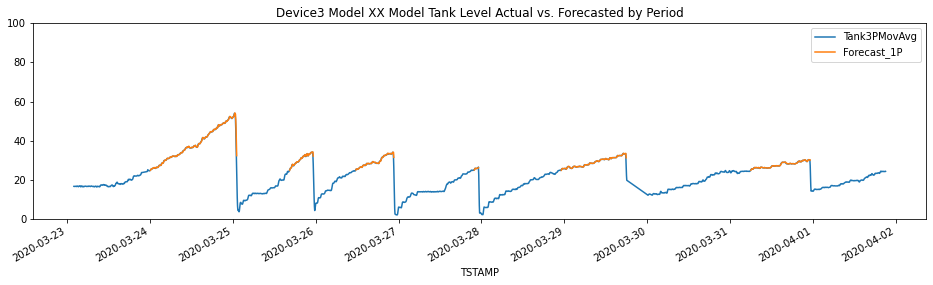

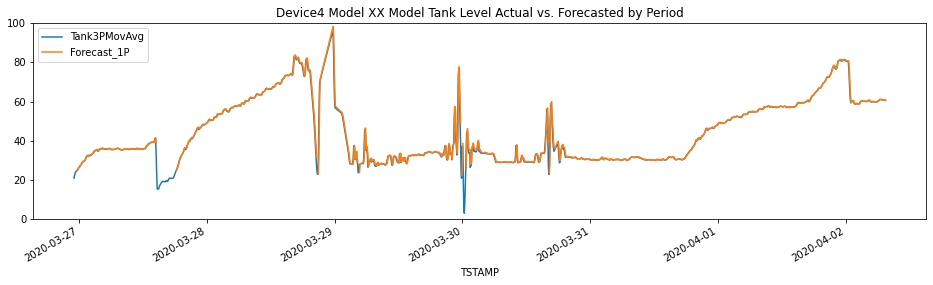

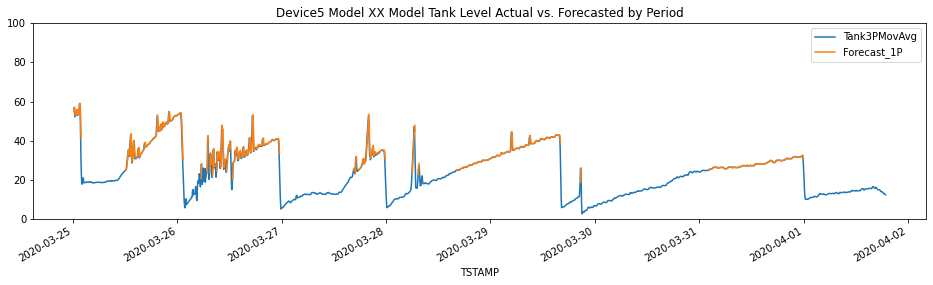

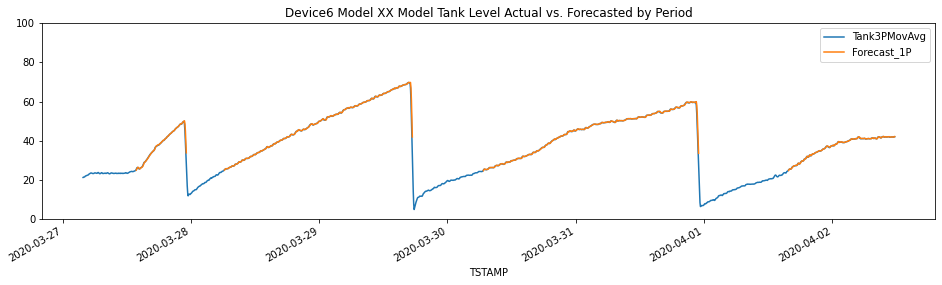

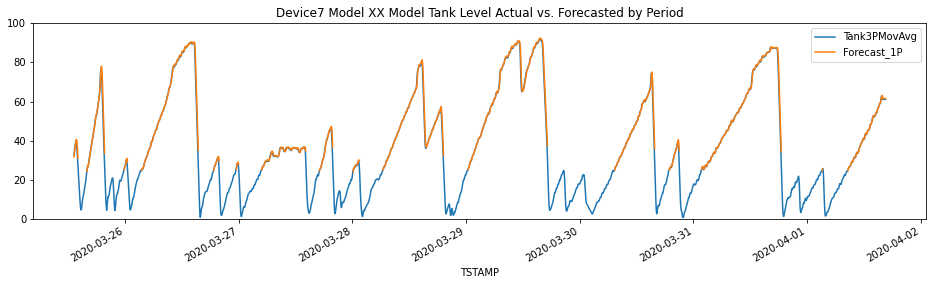

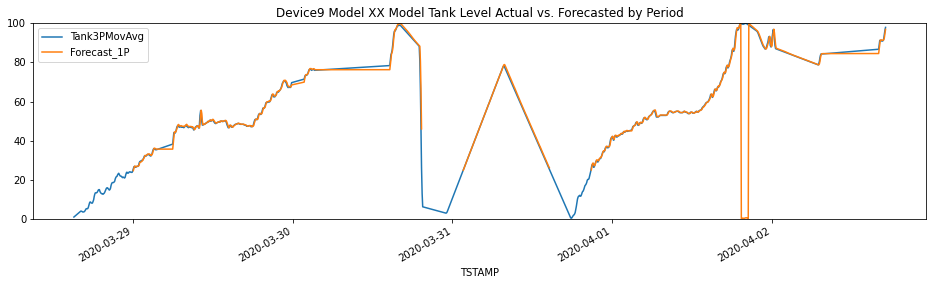

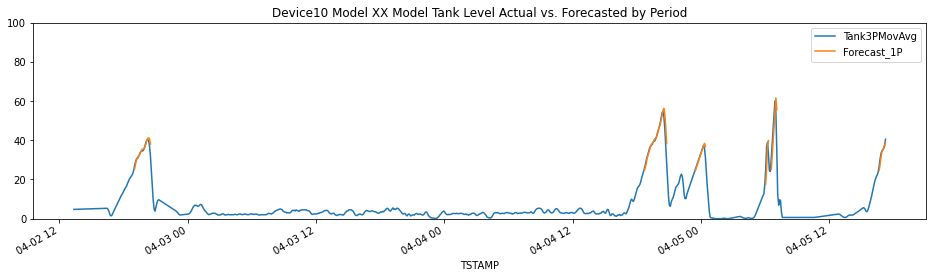

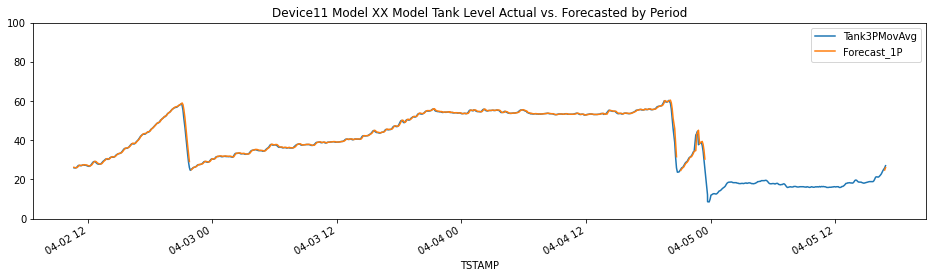

In [15]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_1P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)


## 6 Period Forecasts Model Comparison

### Across all device conditions

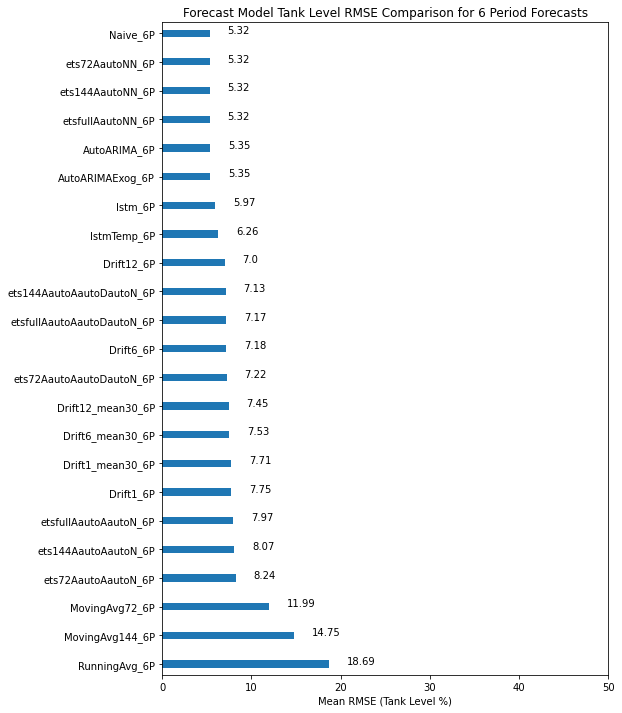

In [16]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[1], pname='6')


In [17]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[1])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")


### Across ideal device conditions

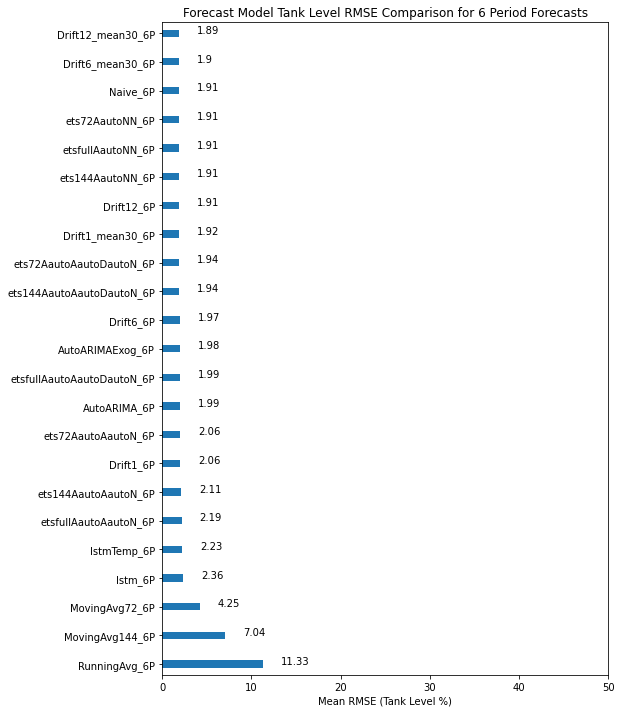

In [18]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[1], pname='6')

In [19]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[1])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")


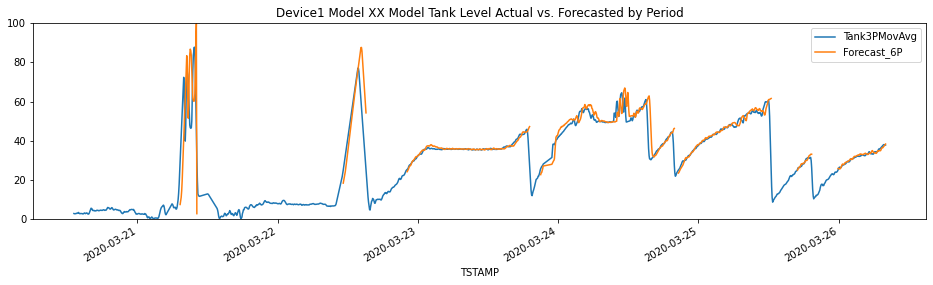

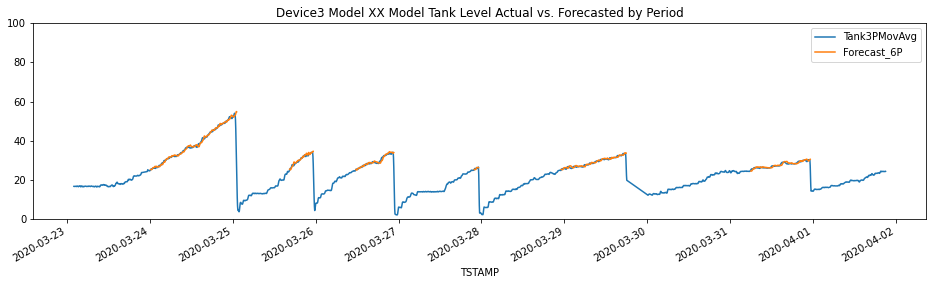

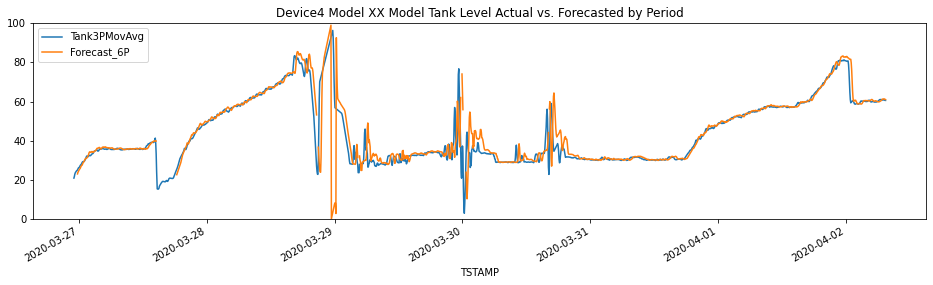

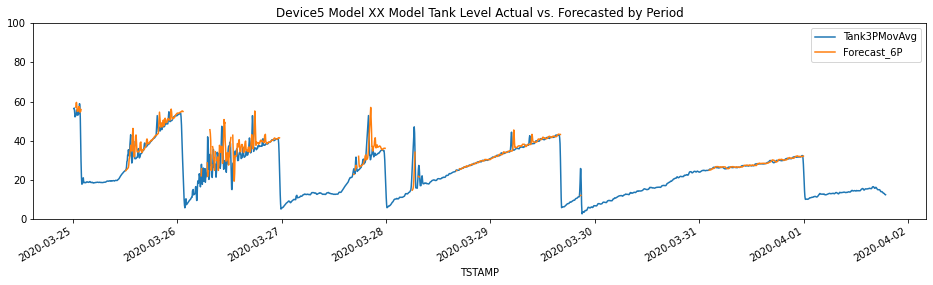

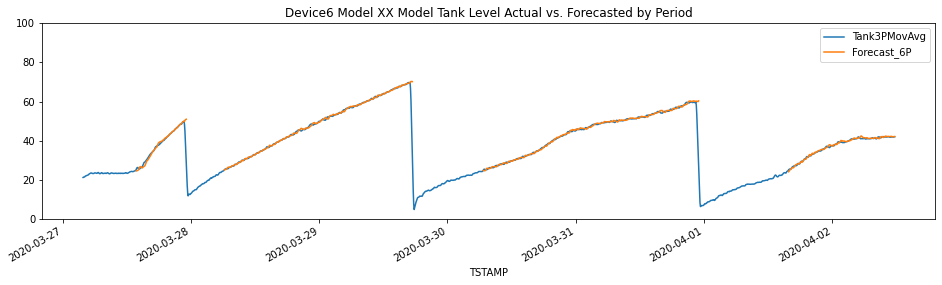

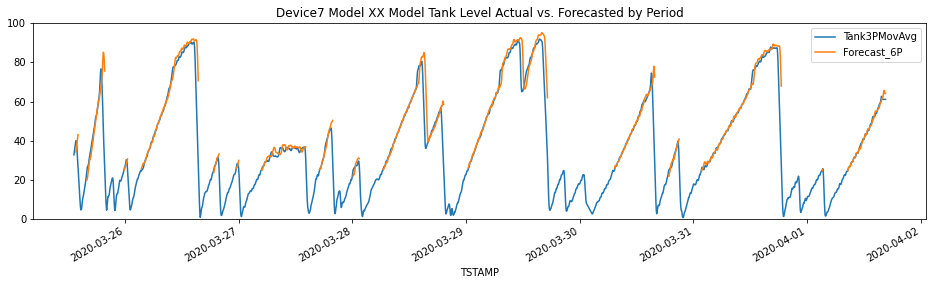

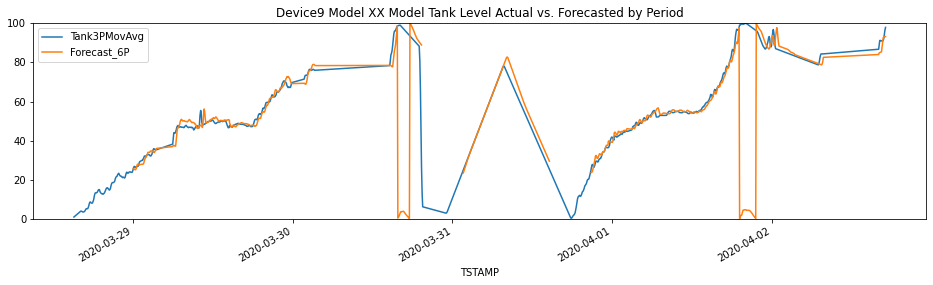

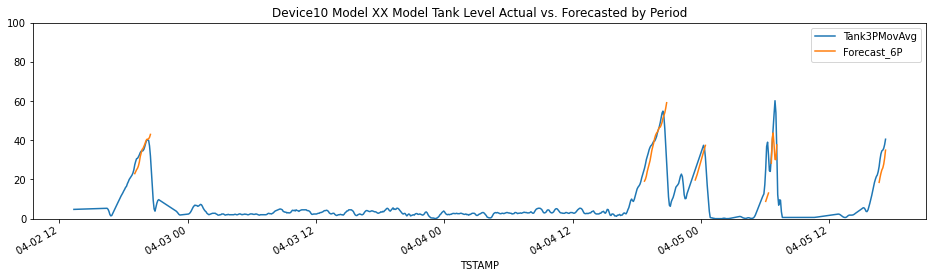

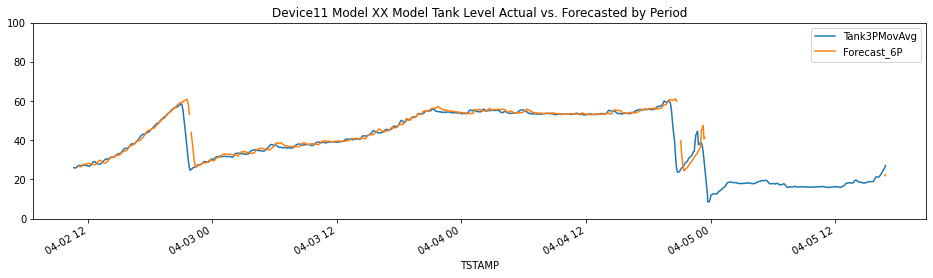

In [20]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)


## 12 Period Forecasts Model Comparison

### Across all device conditions

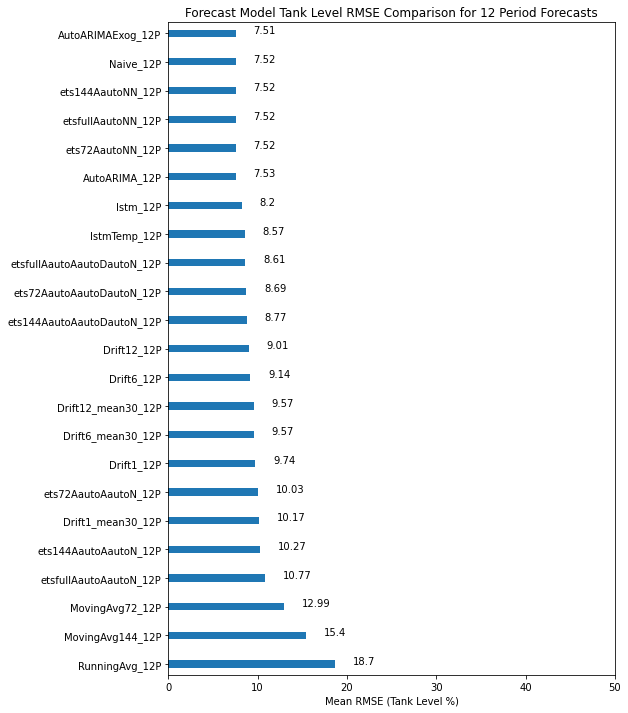

In [21]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[2], pname='12')


In [22]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[2])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

### Across ideal device conditions

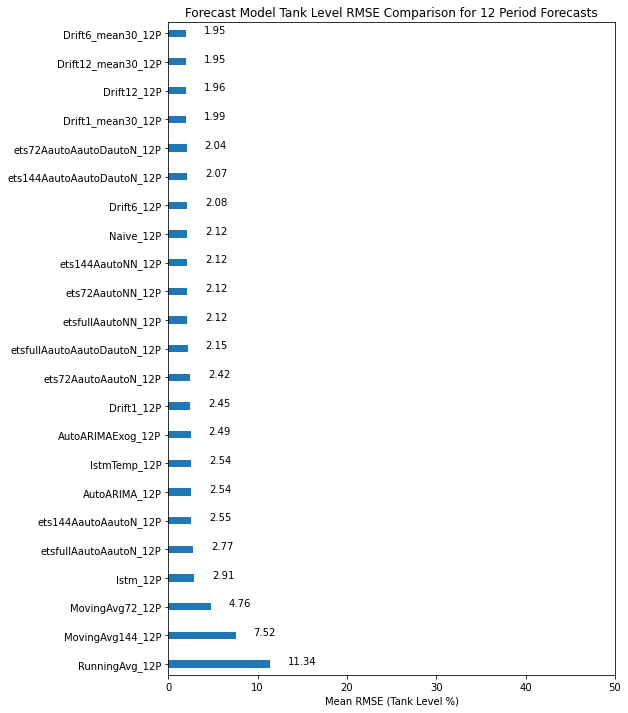

In [23]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[2], pname='12')

In [24]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[2])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

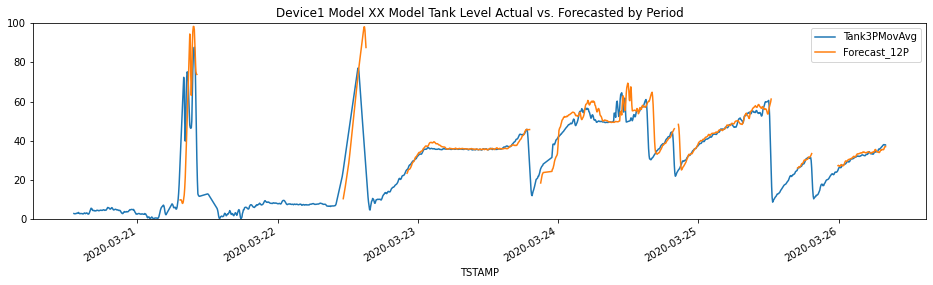

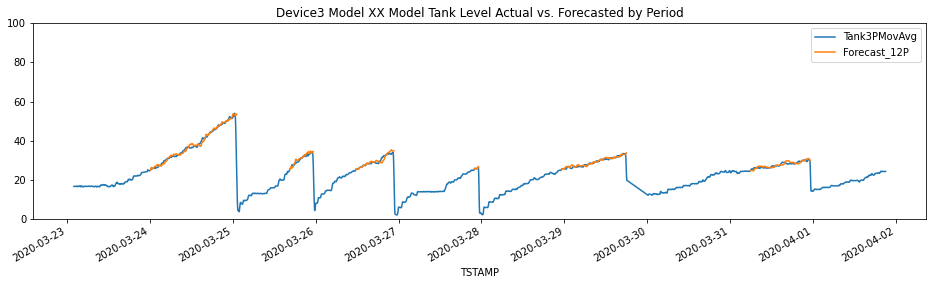

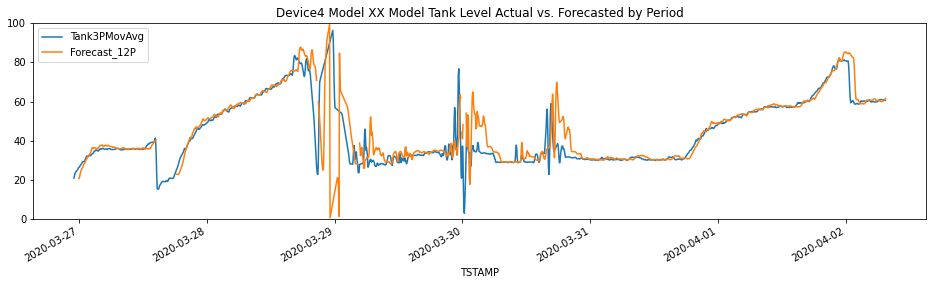

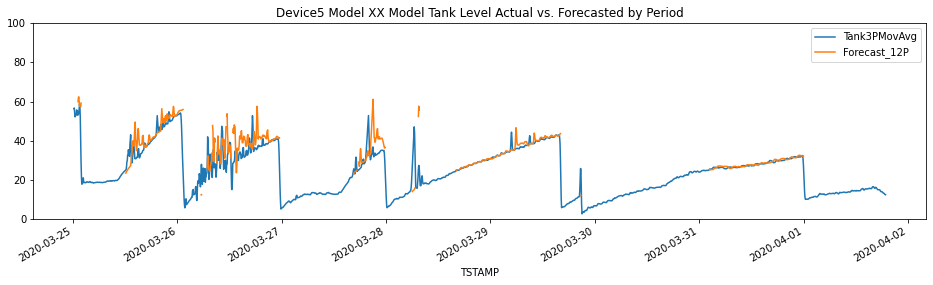

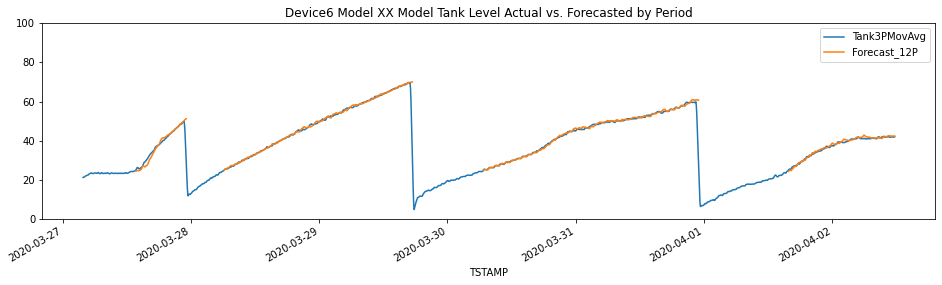

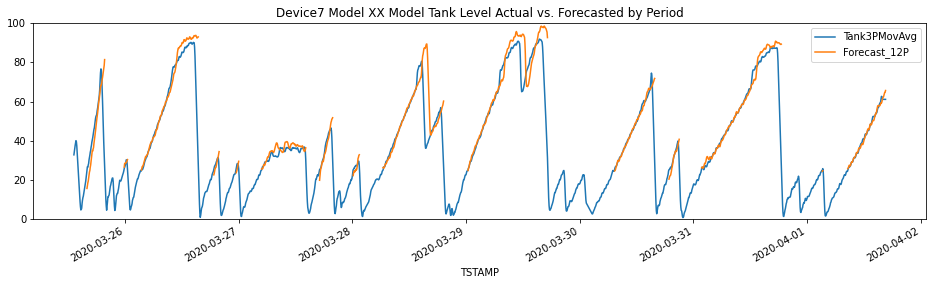

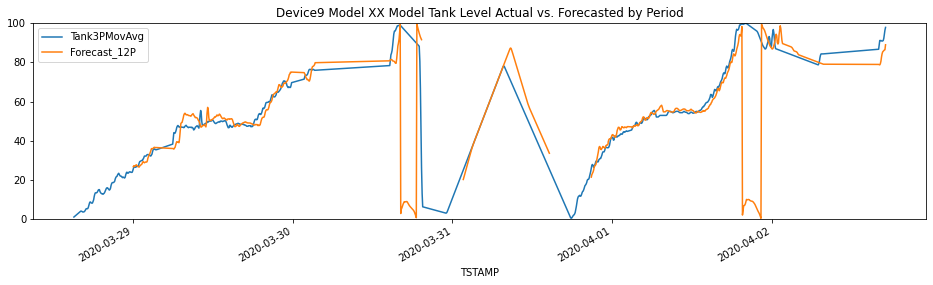

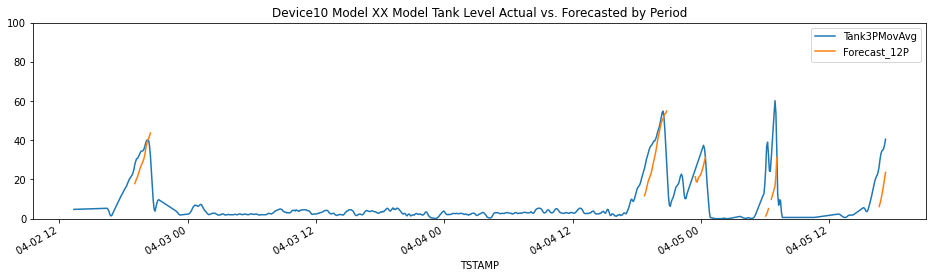

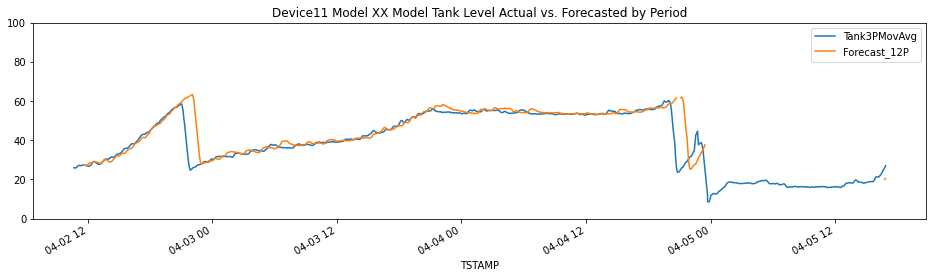

In [25]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_12P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)

## 36 Period Forecasts Model Comparison

### Across all device conditions

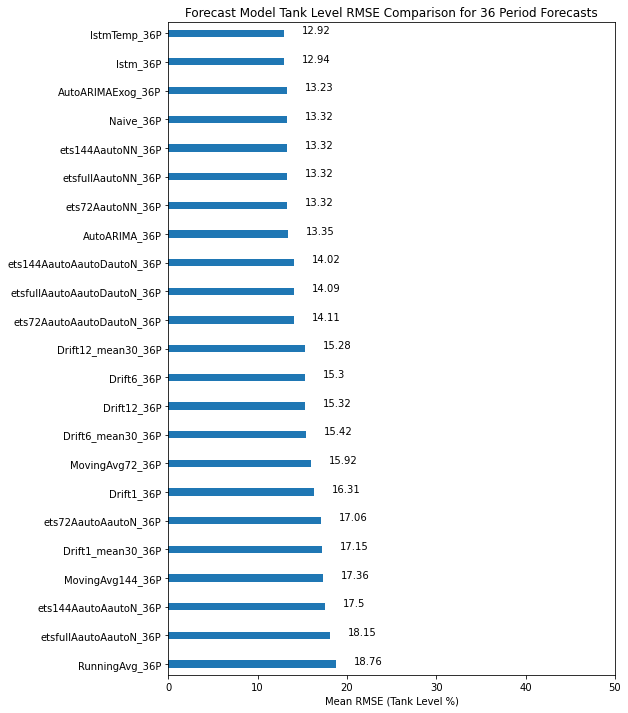

In [26]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[3], pname='36')


In [27]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[3])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

### Across ideal device conditions

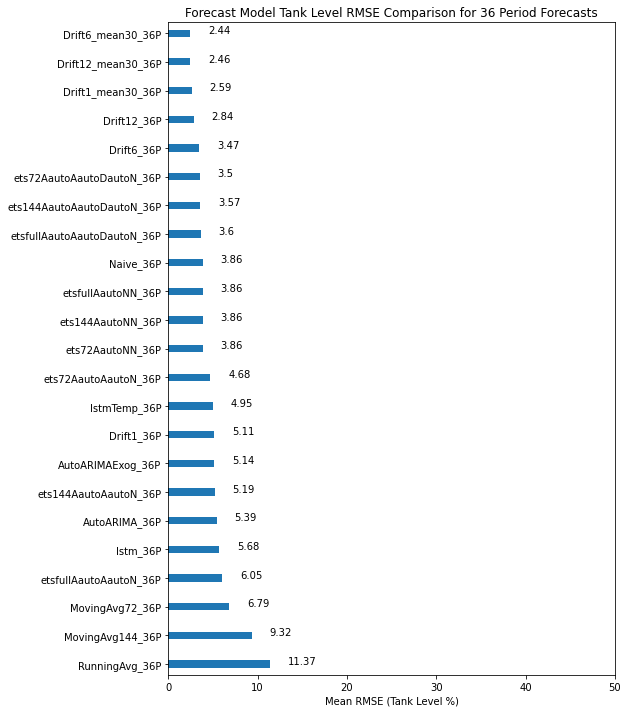

In [28]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[3], pname='36')

In [29]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[3])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

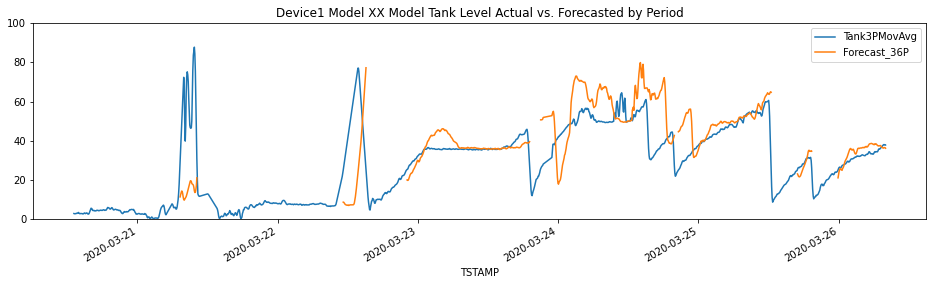

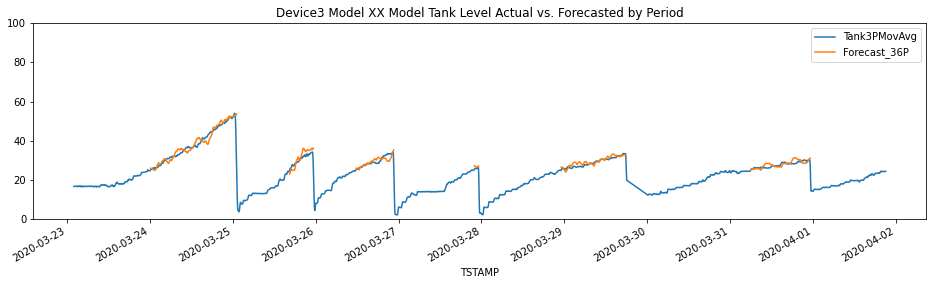

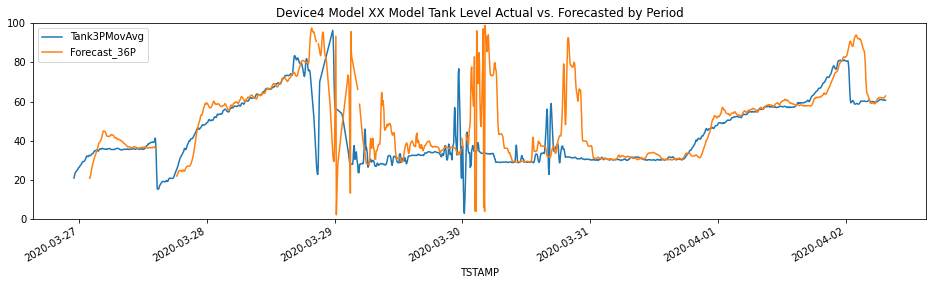

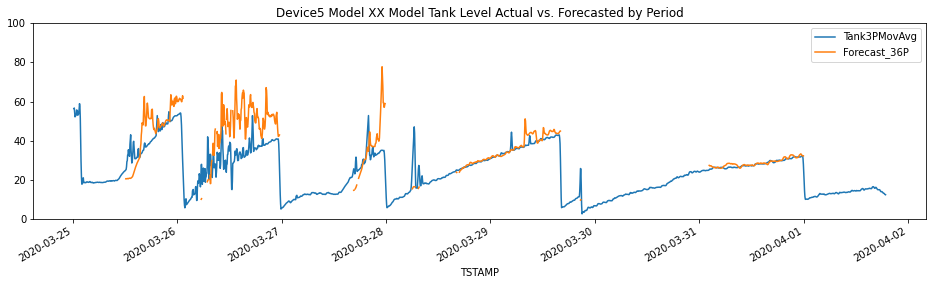

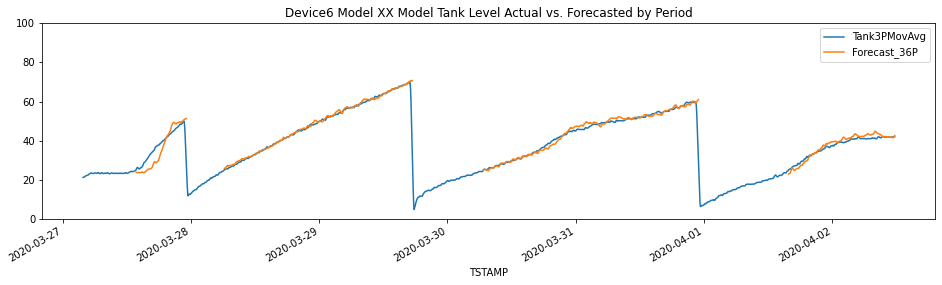

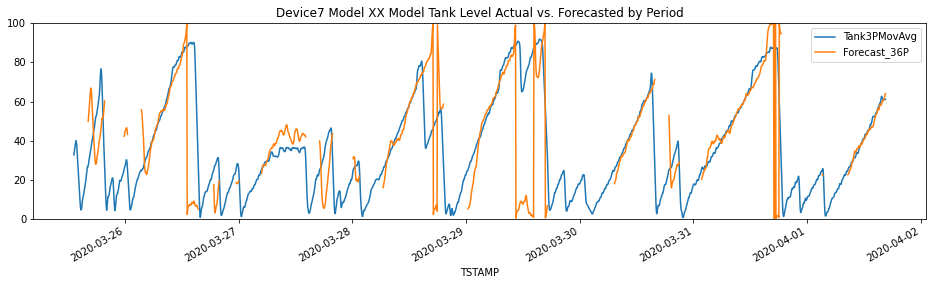

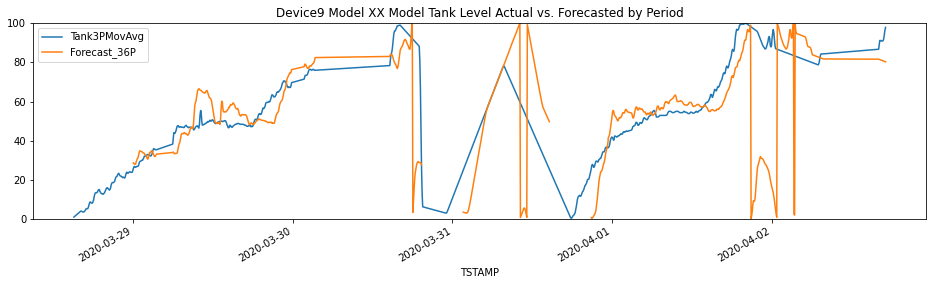

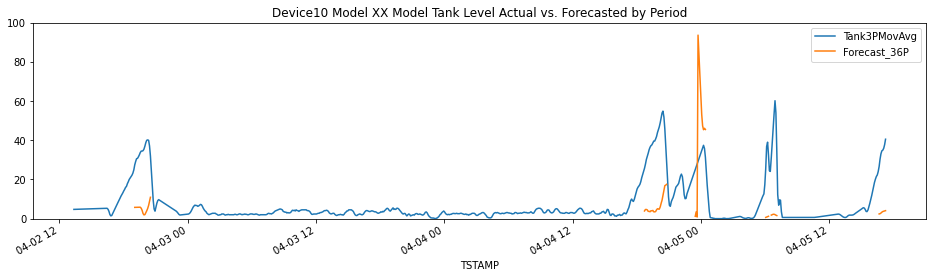

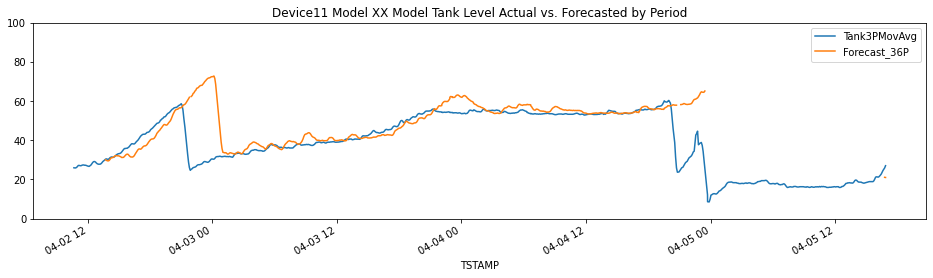

In [30]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_36P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)

## 72 Period Forecasts Model Comparison

### Across all device conditions

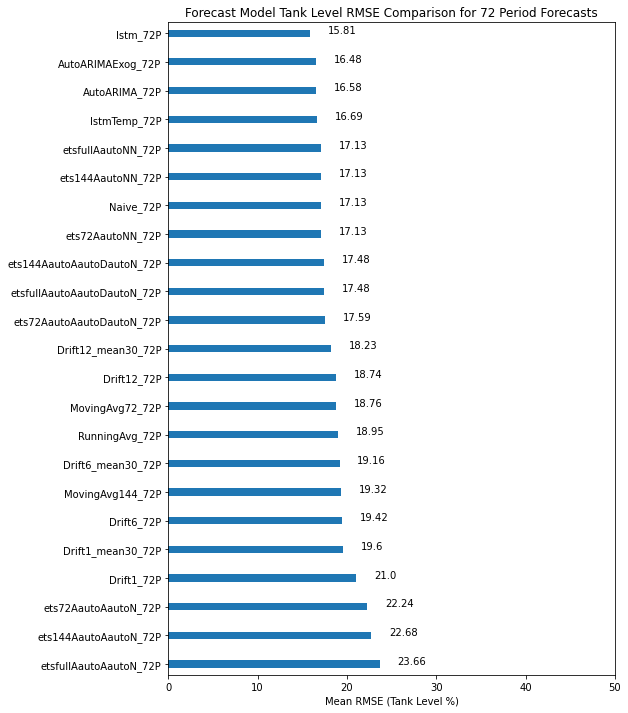

In [31]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[4], pname='72')


In [32]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[4])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

### Across ideal device conditions

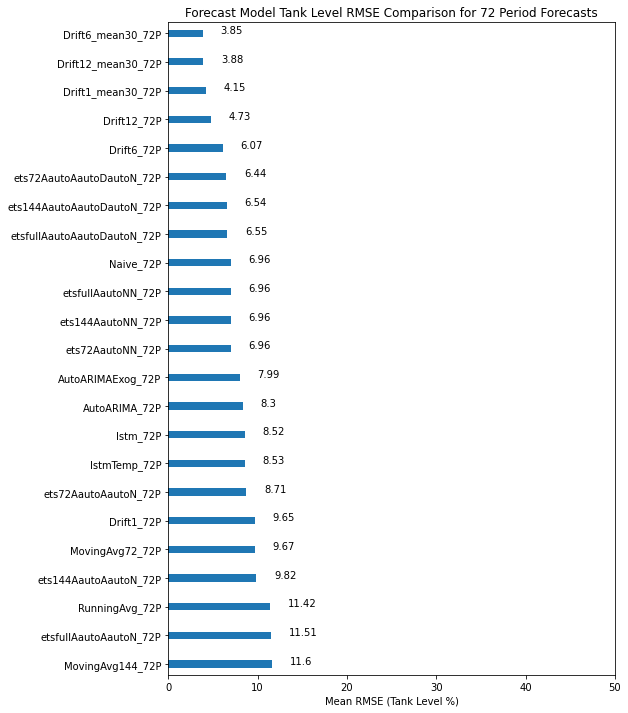

In [33]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[4], pname='72')

In [34]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[4])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

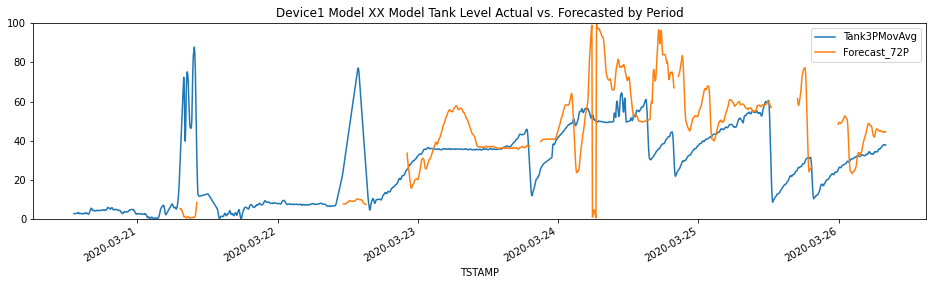

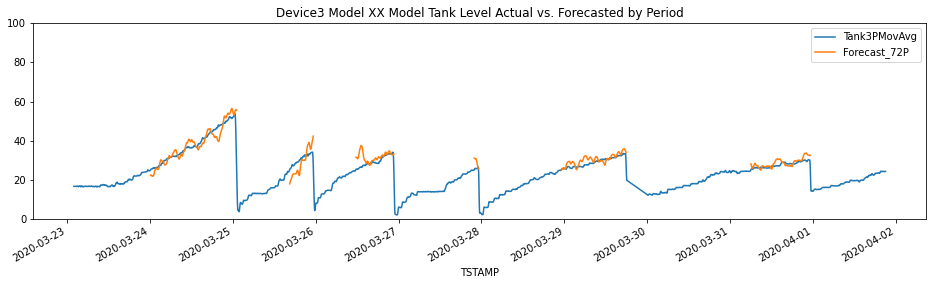

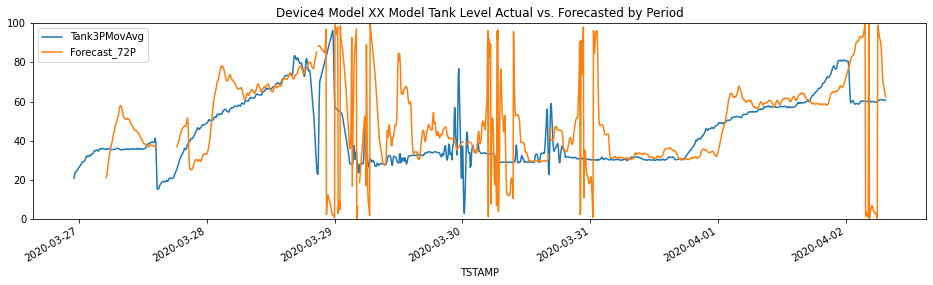

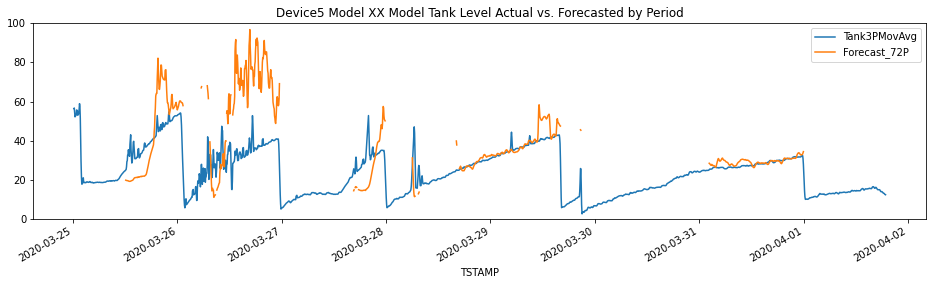

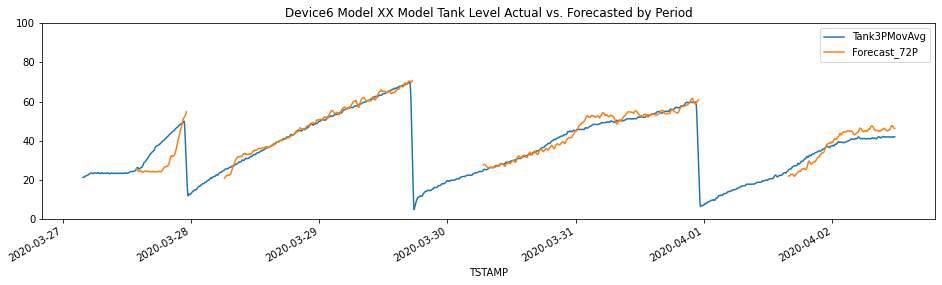

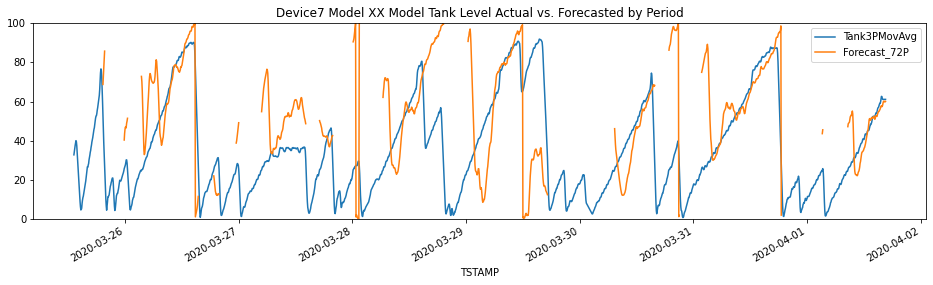

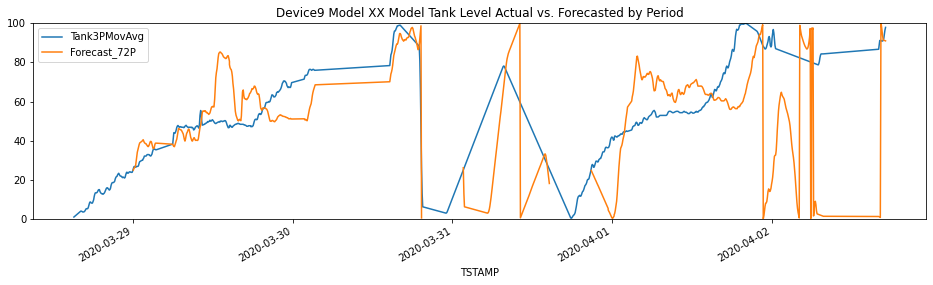

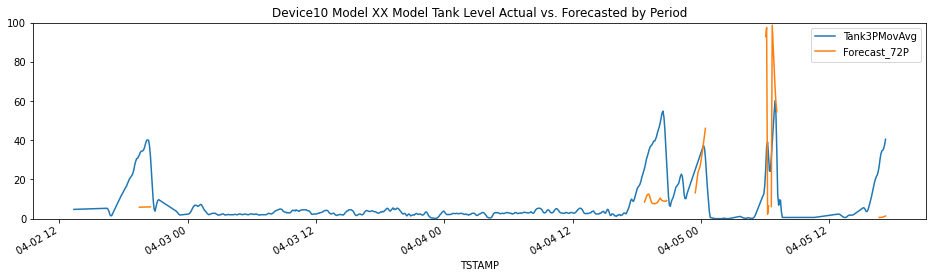

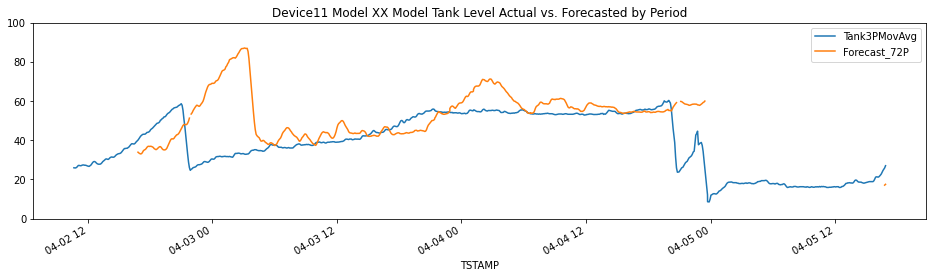

In [35]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_72P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)

## 144 Period Forecasts Model Comparison

### Across all device conditions

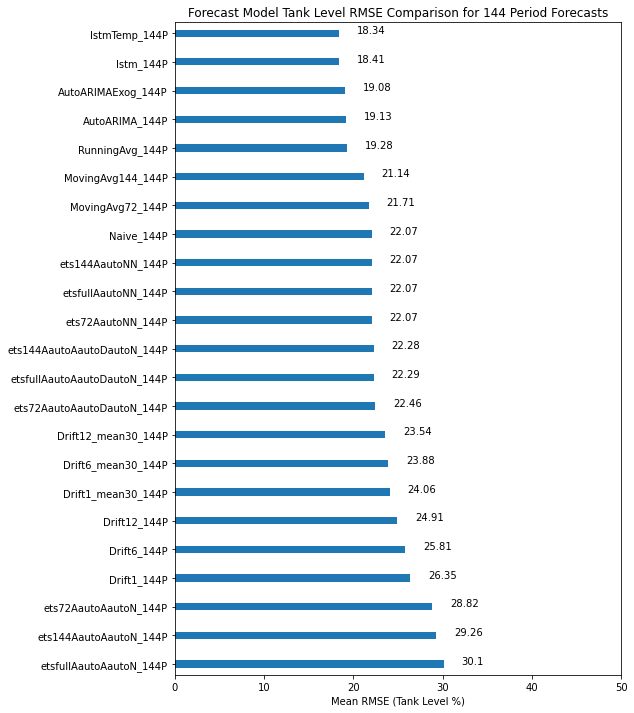

In [36]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[5], pname='144')


In [37]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[5])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

### Across ideal device conditions

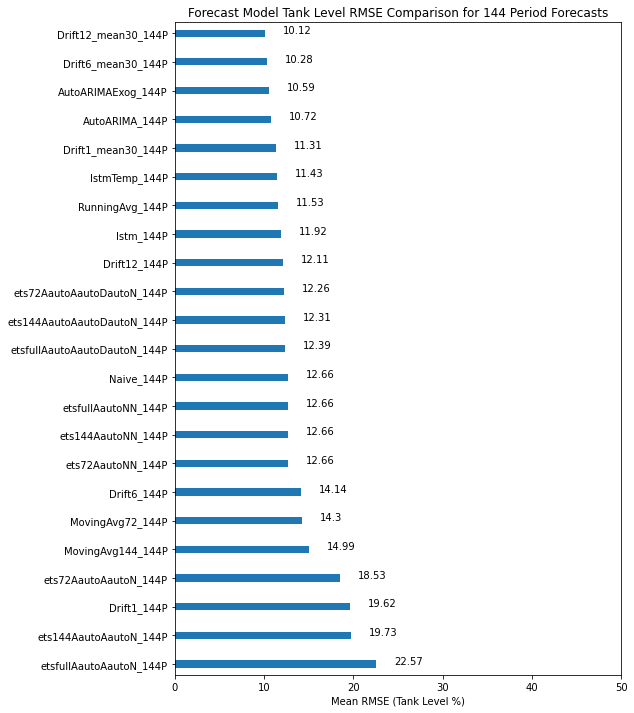

In [38]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[5], pname='144')

In [39]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[5])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

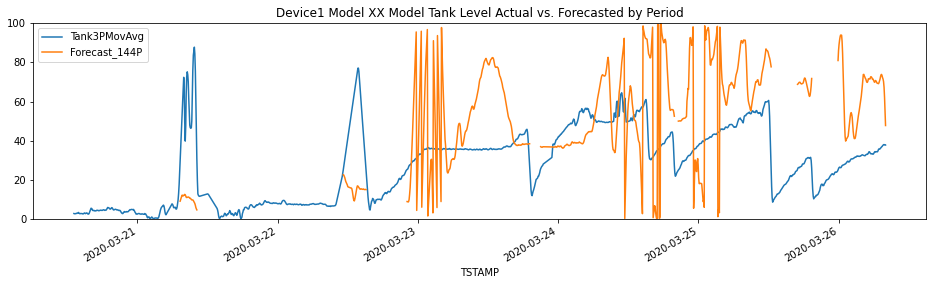

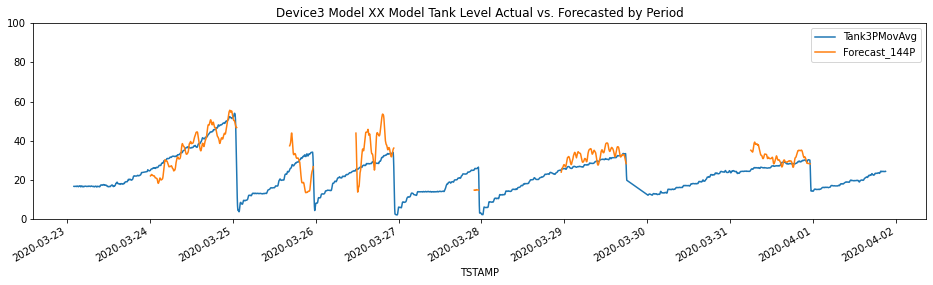

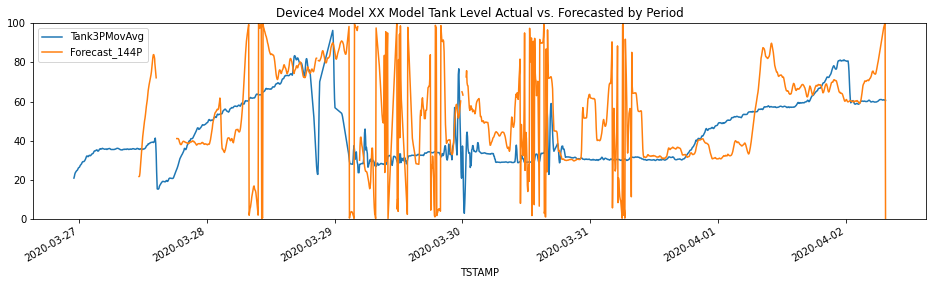

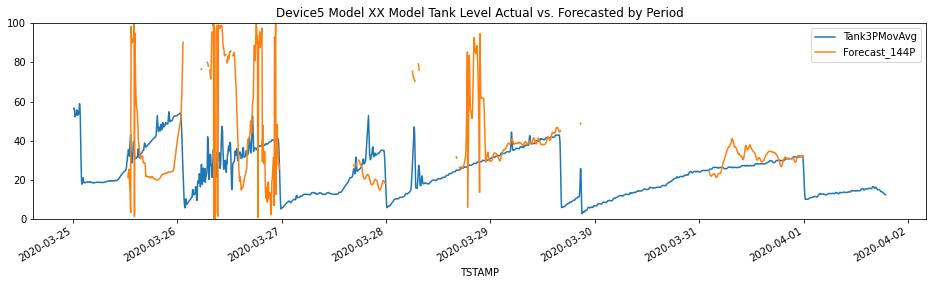

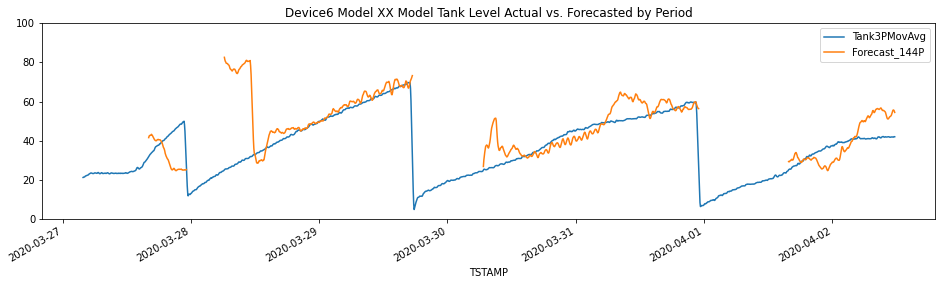

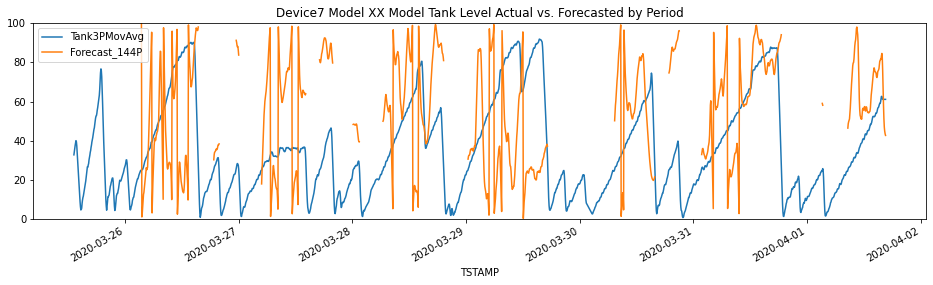

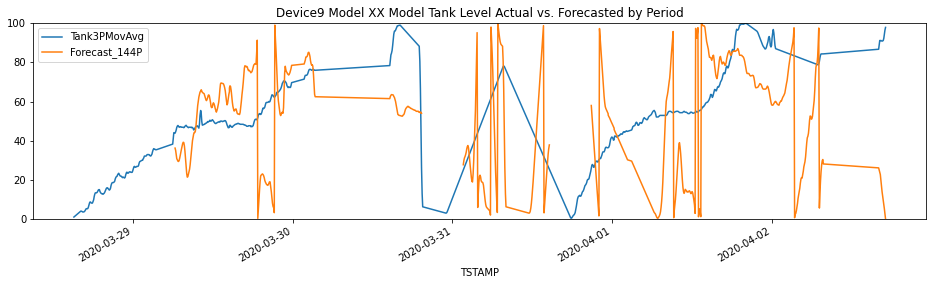

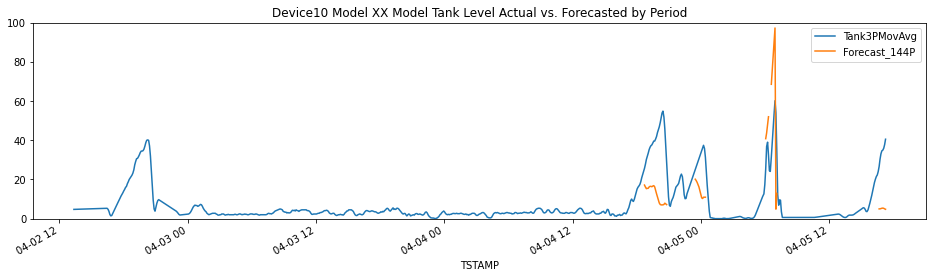

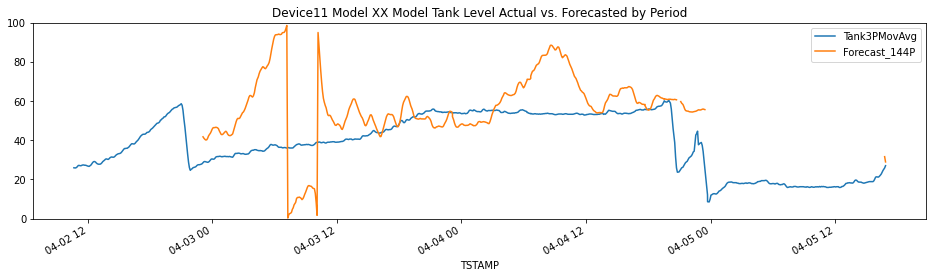

In [40]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_144P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)

## 288 Period Forecasts Model Comparison

### Across all device conditions

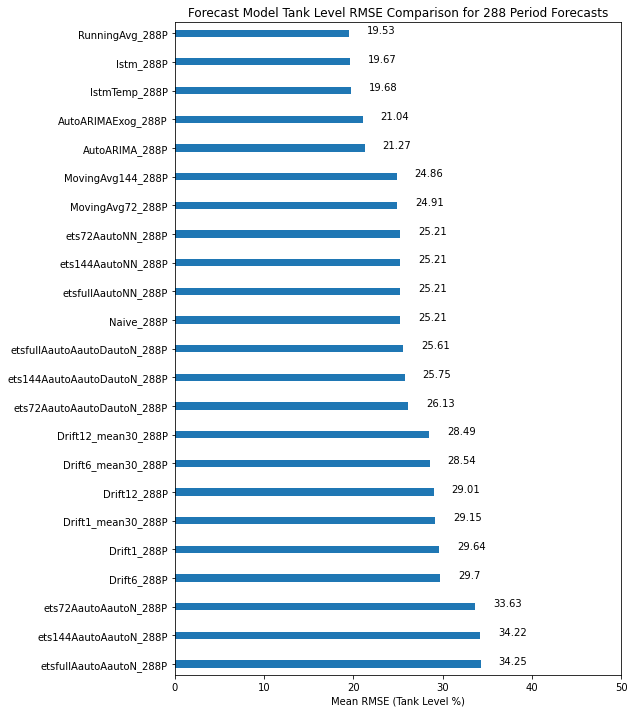

In [41]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_rmse_df, pcols=period_cols[6], pname='288')


In [42]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_rmse_df, period_cols[6])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

### Across ideal device conditions

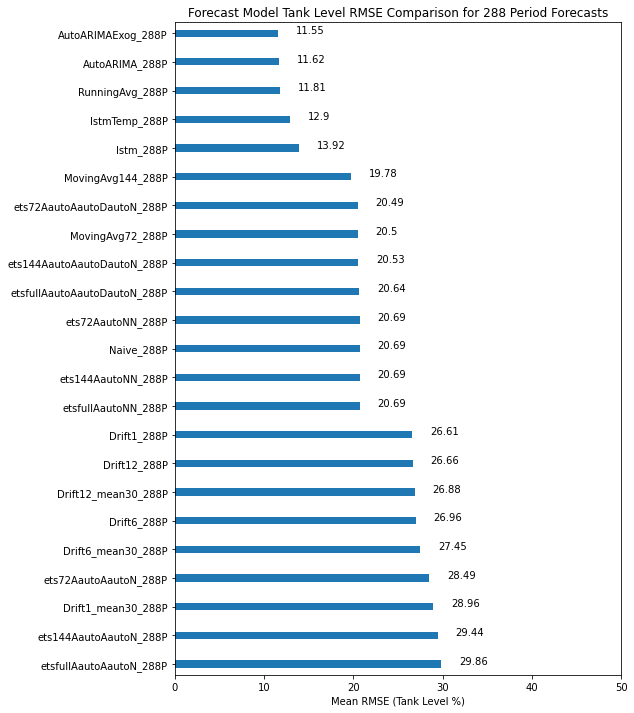

In [43]:
# plot model results
%matplotlib inline

plot_model_rmse_comparison(df=allmodels_ideal_rmse_df, pcols=period_cols[6], pname='288')

In [44]:
# display rmse values with inline bar chart
df = df_model_rmse_comparison(allmodels_ideal_rmse_df, period_cols[6])

df.style.bar(color="#F8DAD5", vmax=40).format("{:.2f}")

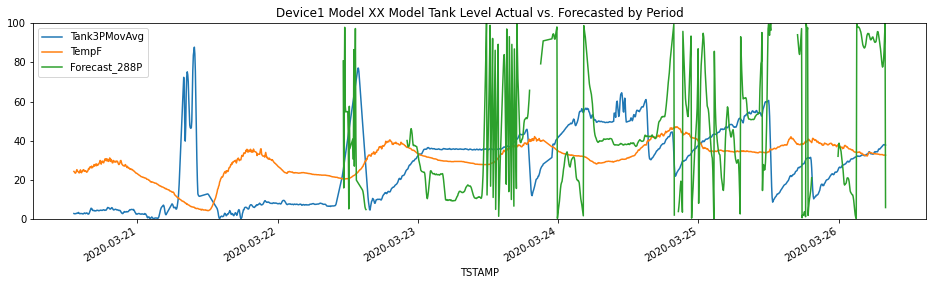

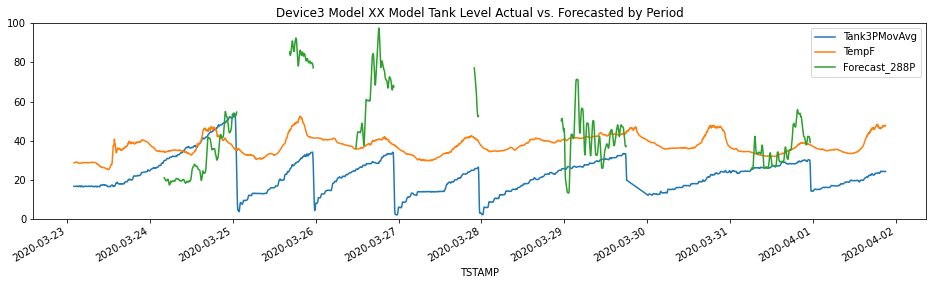

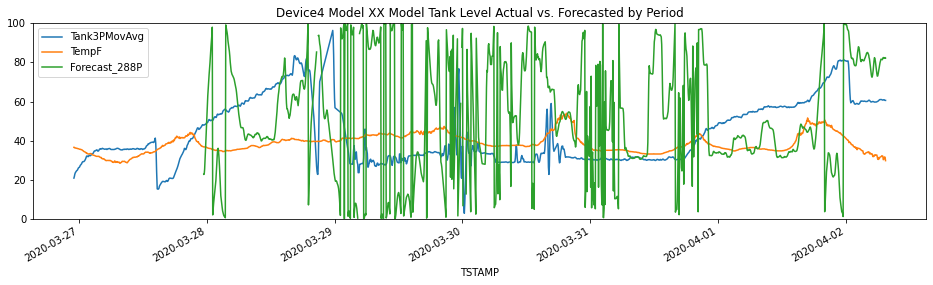

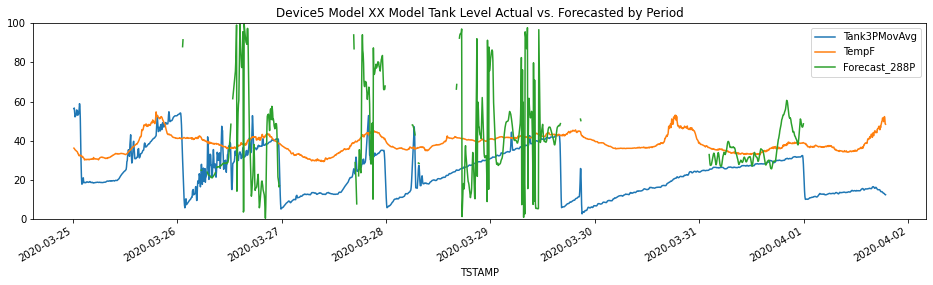

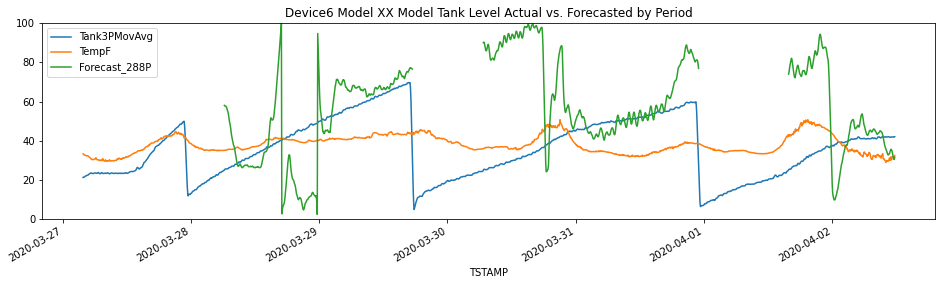

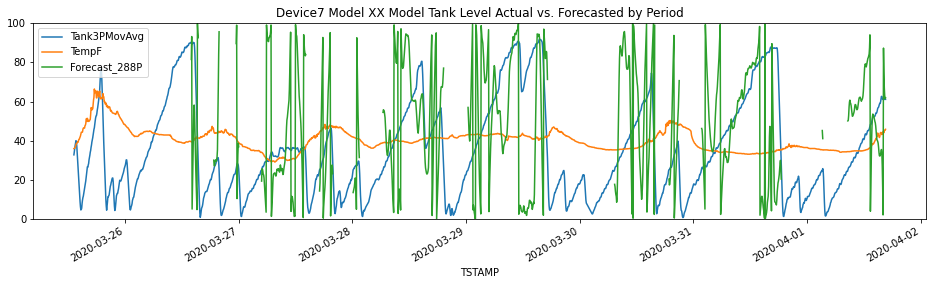

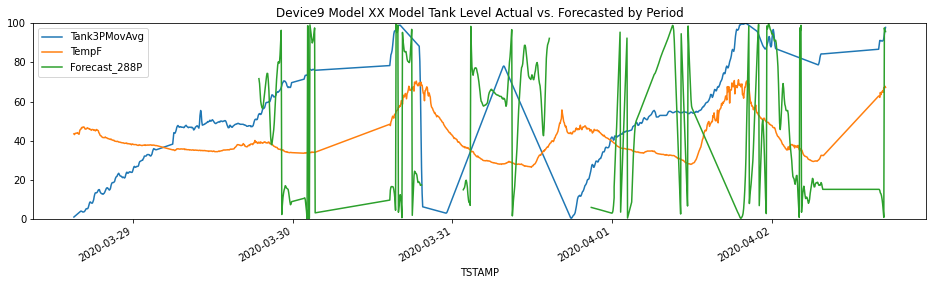

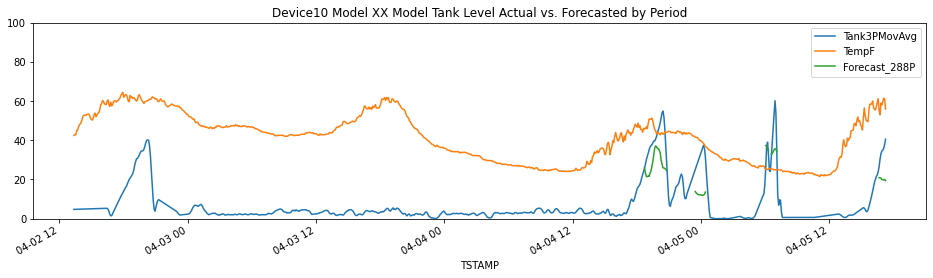

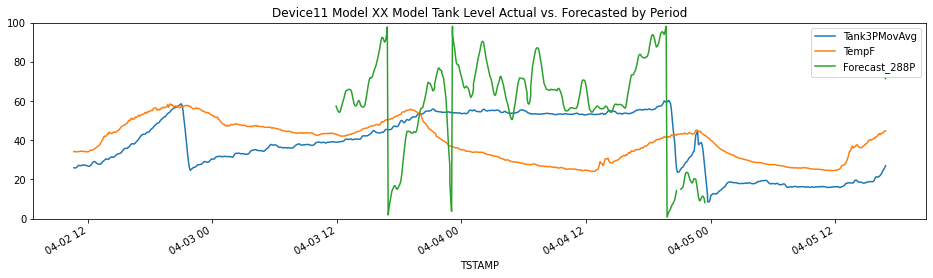

In [45]:
# plot model forecasts with test data:  actual vs. forecast
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
device_ids = [1, 3, 4, 5, 6, 7, 9, 10, 11]
forecasts = forecastcsv_to_dfs(file='data/Drift6_Mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg', 'TempF']
forecast_cols = ['Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Model XX', flt_thrsh)

## Miscellaneous Comparison and Visualization

### Forecast Evaluation Range Visual

Visualizes a device test set with the ranges highlighted that were excluded from forecast RMSE evaluation.  These excluded ranges were where the tank level was below the defined threshold.

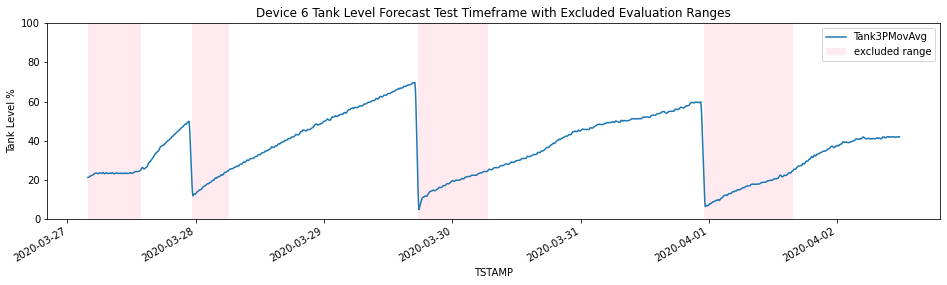

In [46]:
import matplotlib.dates as mdates

# function to visualize exluded forecast ranges with matplotlib vertical-span function
def highlight_excluded_range(data, ax, thresh=25):
    # get time index of series
    idx = data.index
    # initialize the excluded range start
    rstart = 0
    # initialize the count of exluded ranges
    rr = 0
    for i in range(len(data)):
        if data.iloc[i].values < thresh and rstart == 0: # range start
            rstart = mdates.date2num(idx[i])
        elif data.iloc[i].values >= thresh and rstart > 0: # range end
            rend = mdates.date2num(idx[i-1])
            ax.axvspan(rstart, rend, facecolor='pink', alpha=0.3, label="excluded range" if rr == 0 else "_nolegend")
            rr += 1
            # reset exluded range
            rstart = 0
            rend = 0
    # end loop, and check if the last excluded range must be closed
    if rstart > 0:
        rend = mdates.date2num(idx[i])
        ax.axvspan(rstart, rend, facecolor='pink', alpha=0.3, label="excluded range" if rr == 0 else "_nolegend")
    # display legend
    ax.legend()


# get dfs from forecast file
device_ids = [6]
forecasts = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
plot_cols = ['Tank3PMovAvg']

# set plot objects
fig, ax = plt.subplots(figsize=(16,4) )

# create initial plot
forecasts[6][plot_cols].plot(ax=ax,
    title = f'Device 6 Tank Level Forecast Test Timeframe with Excluded Evaluation Ranges', 
    ylabel = ('Tank Level %'),
    ylim=(0,100))

# add exluded forecast ranges on plot
highlight_excluded_range(forecasts[6][plot_cols], ax, thresh=25)
        


### Device Tank Levels During Forecast Test Timeframes Visual

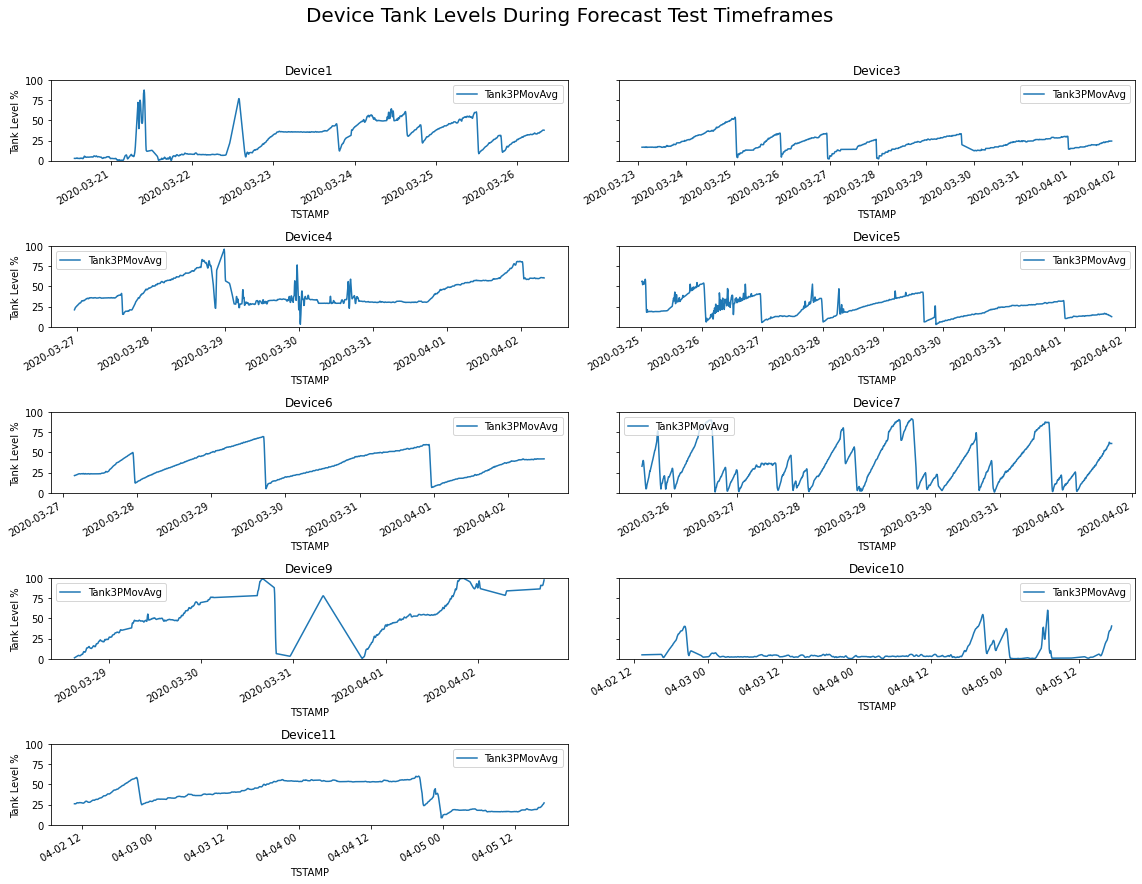

In [47]:
# plot tank levels for each device within the test range
%matplotlib inline

# get dfs from forecast file
device_ids = [1,3,4,5,6,7,9,10,11]
forecasts = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)

plot_cols = ['Tank3PMovAvg']

fig, axs = plt.subplots(ncols=2, nrows=((len(device_ids)//2)+1), figsize=(16,12))
fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)

# seed subplot row counter
c = 0
for ii in device_ids:
    # create scatterplot for each device
    # create initial plot
    forecasts[ii][plot_cols].plot(ax=axs[c//2][c%2],
        ylim=(0,100))    
    
    # title each subplot
    axs[c//2][c%2].set_title(f'Device{ii}', size=12, y=1.0)
    # label the y-axis for the left column
    if (c%2) == 0:
        axs[c//2][c%2].set_ylabel('Tank Level %')    
    else:
        axs[c//2][c%2].set_ylabel('')
    # remove y-axis tick labels except for left column
    if (c%2) != 0:
        axs[c//2][c%2].set_yticklabels([])

    c += 1
axs[4][1].set_visible(False)

plt.tight_layout()

### 1 Period Forecast Plots

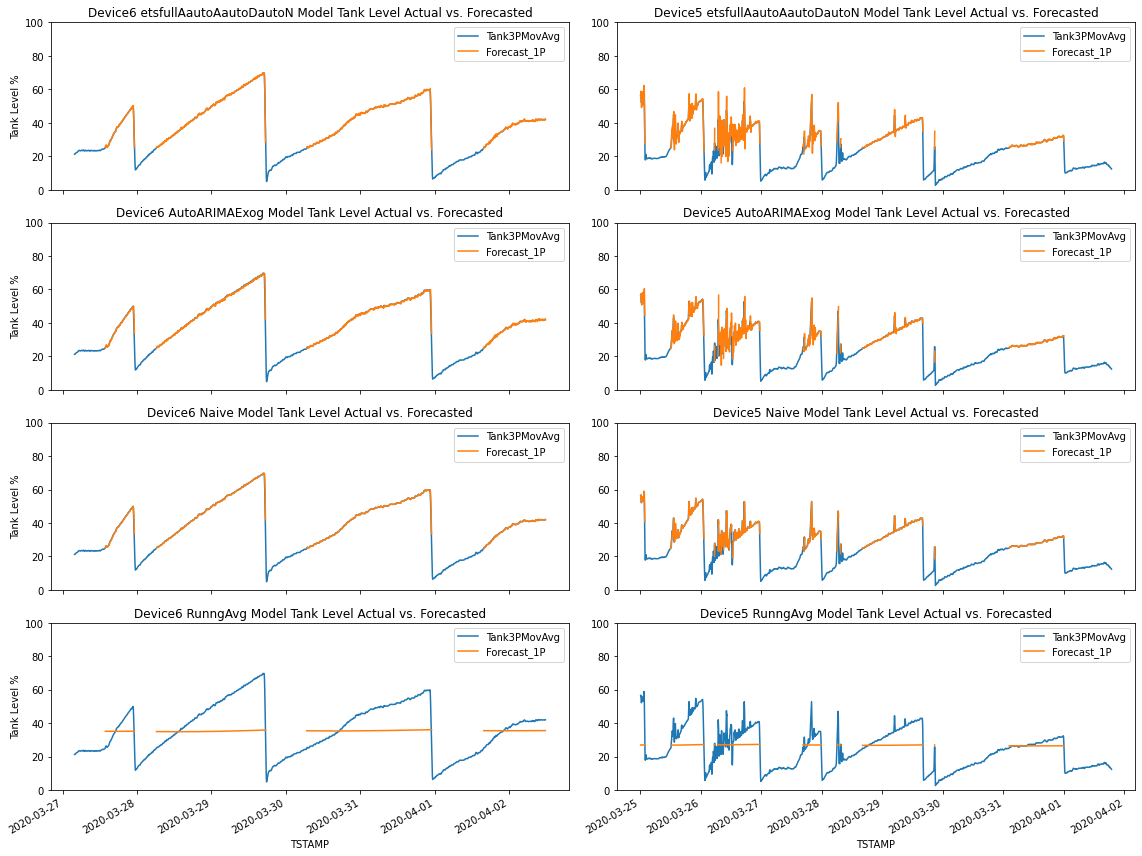

In [48]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "etsfullAautoAautoDautoN"
allmod = "AutoARIMAExog"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_1P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/etsfullAautoAautoDautoN_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/AutoARIMAExog_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/1Pforecastplots.png')

### 6 Period Forecast Plots

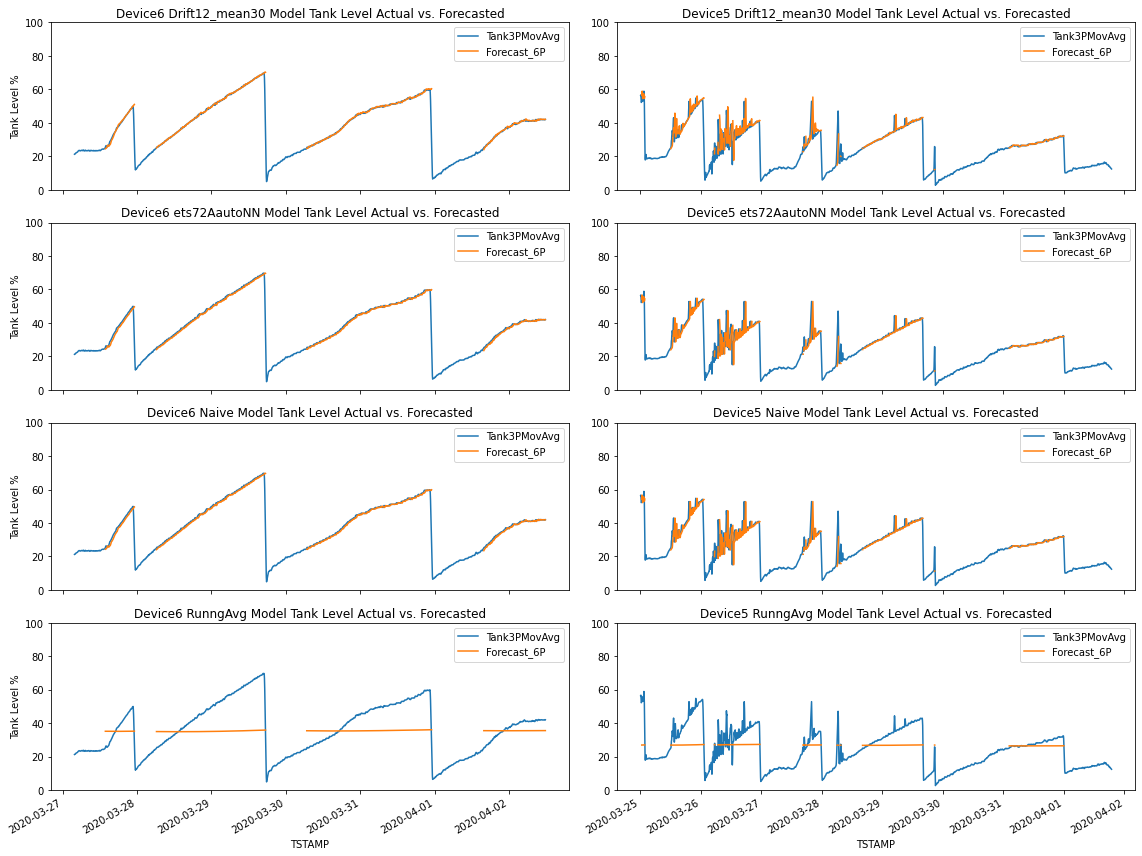

In [49]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "Drift12_mean30"
allmod = "ets72AautoNN"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/Drift12_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/ets72AautoNN_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/6Pforecastplots.png')

### 12 Period Forecast Plots

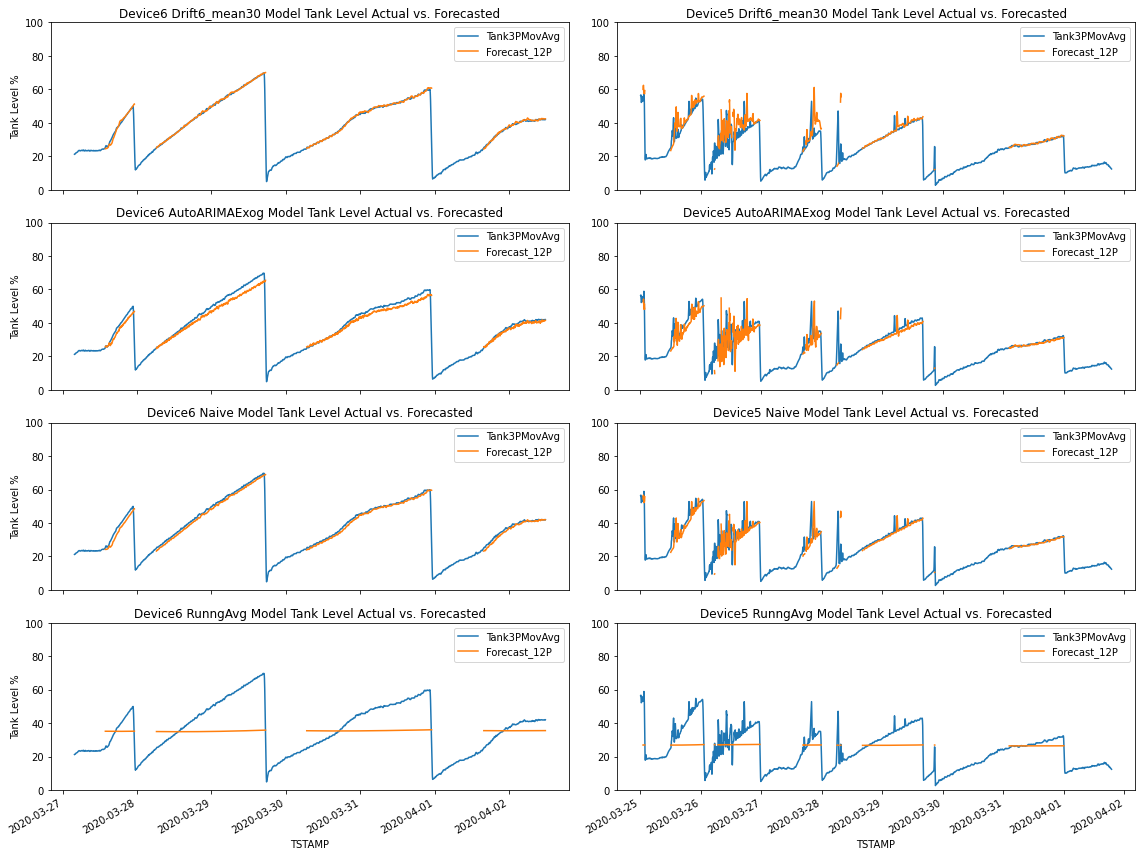

In [50]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "Drift6_mean30"
allmod = "AutoARIMAExog"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_12P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/AutoARIMAExog_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/12Pforecastplots.png')

### 36 Period Forecast Plots

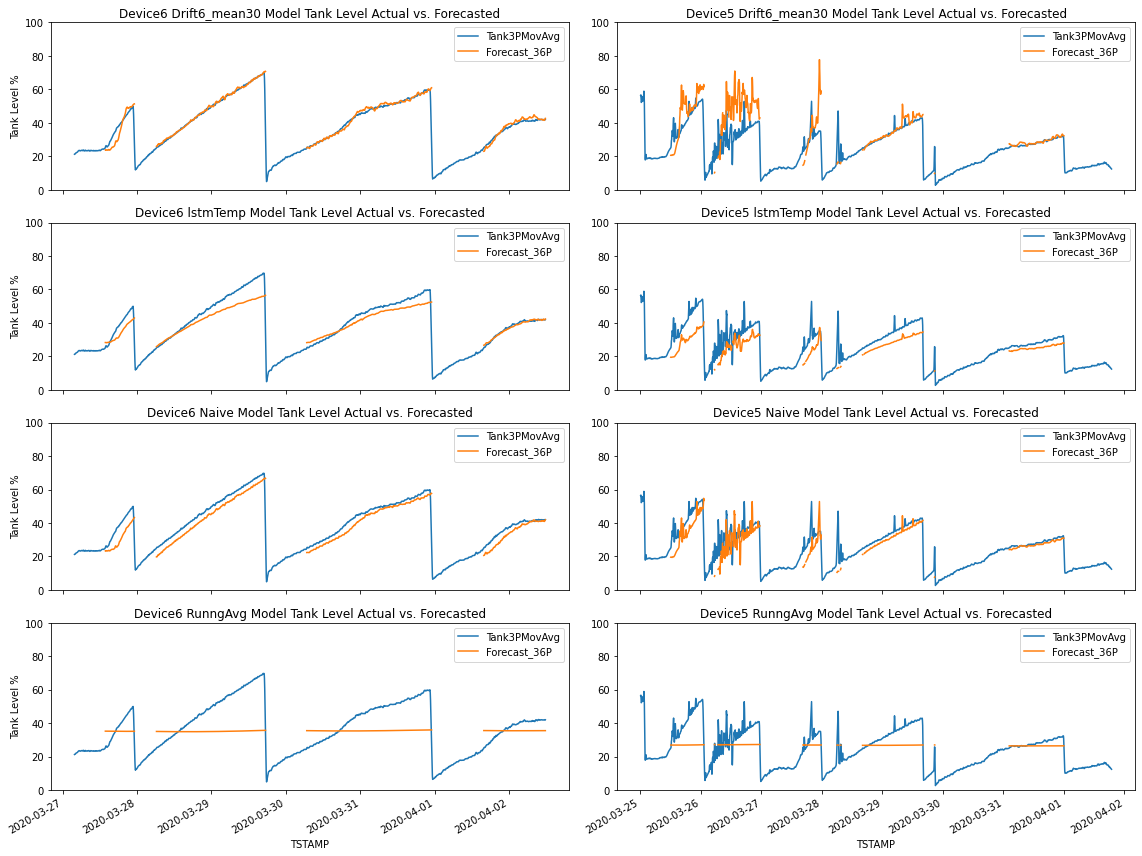

In [51]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "Drift6_mean30"
allmod = "lstmTemp"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_36P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/lstmTemp_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/36Pforecastplots.png')

### 72 Period Forecast Plots

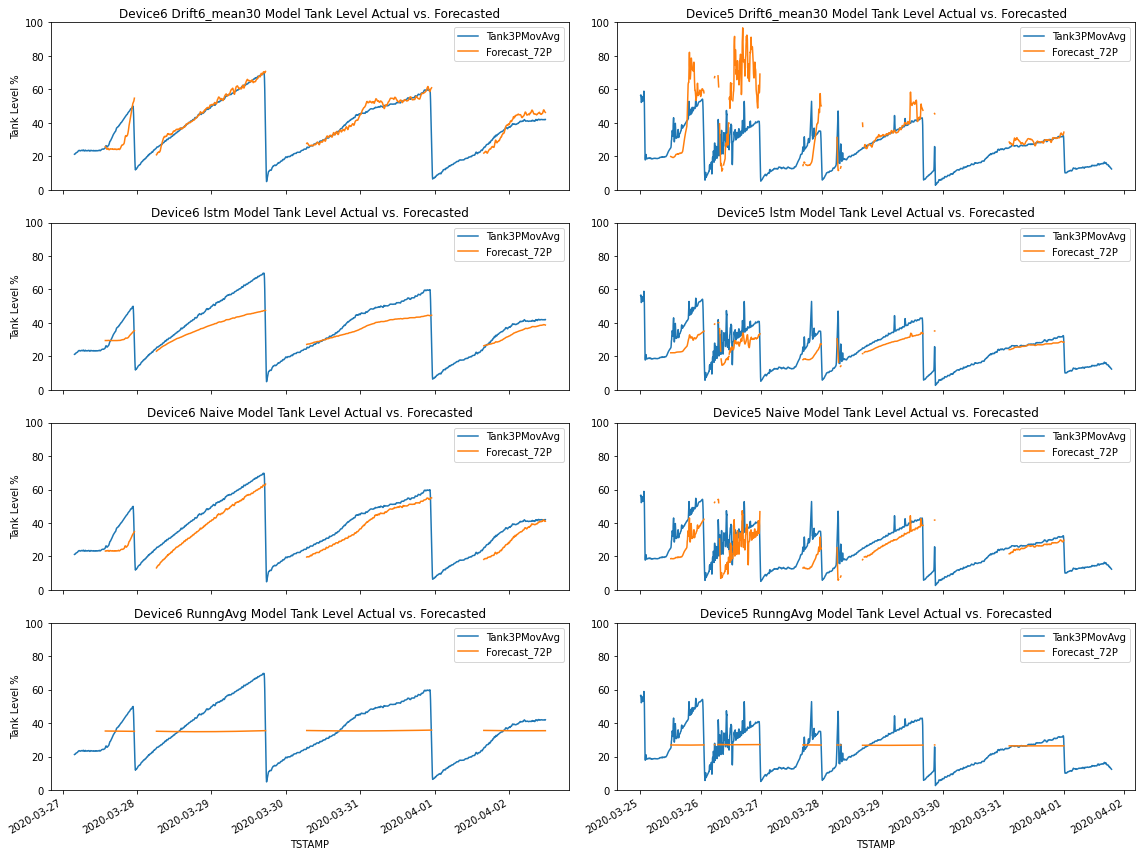

In [52]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "Drift6_mean30"
allmod = "lstm"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_72P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/Drift6_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/lstm_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/72Pforecastplots.png')

### 144 Period Forecast Plots

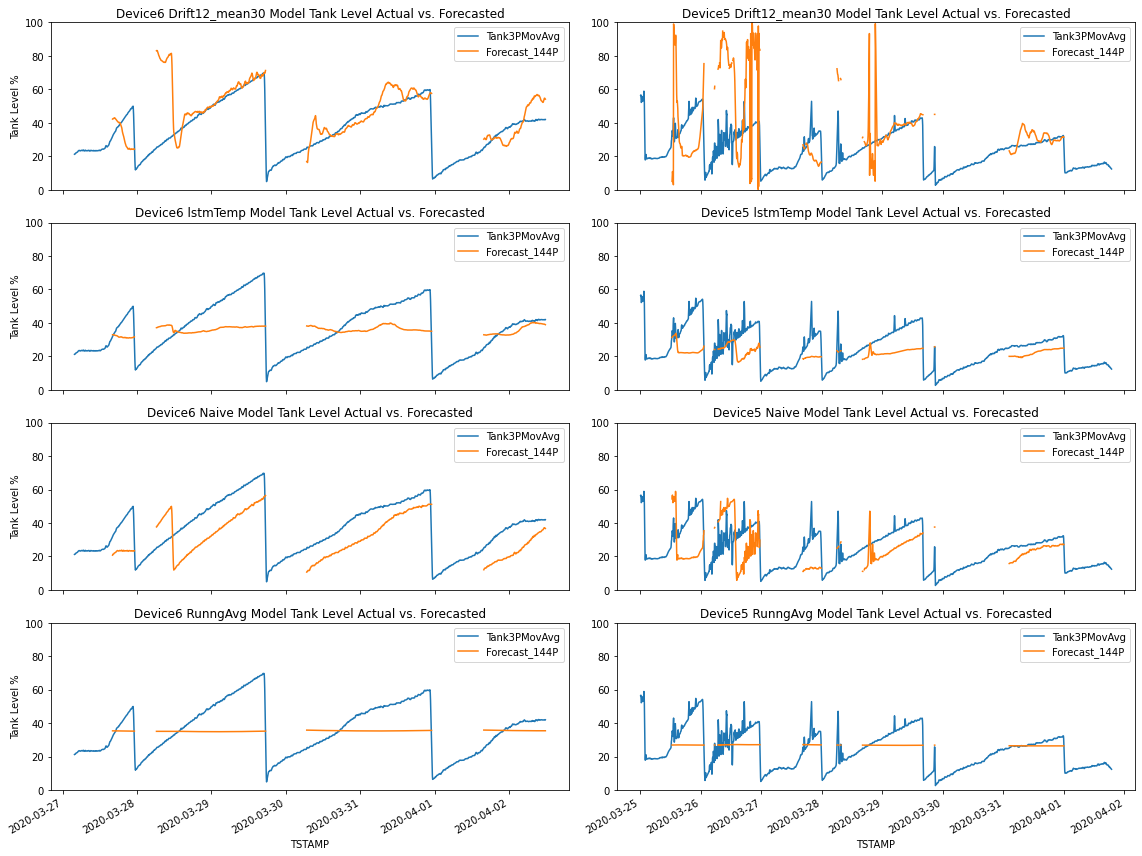

In [53]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "Drift12_mean30"
allmod = "lstmTemp"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_144P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/Drift12_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/lstmTemp_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/144Pforecastplots.png')

### 288 Period Forecast Plots

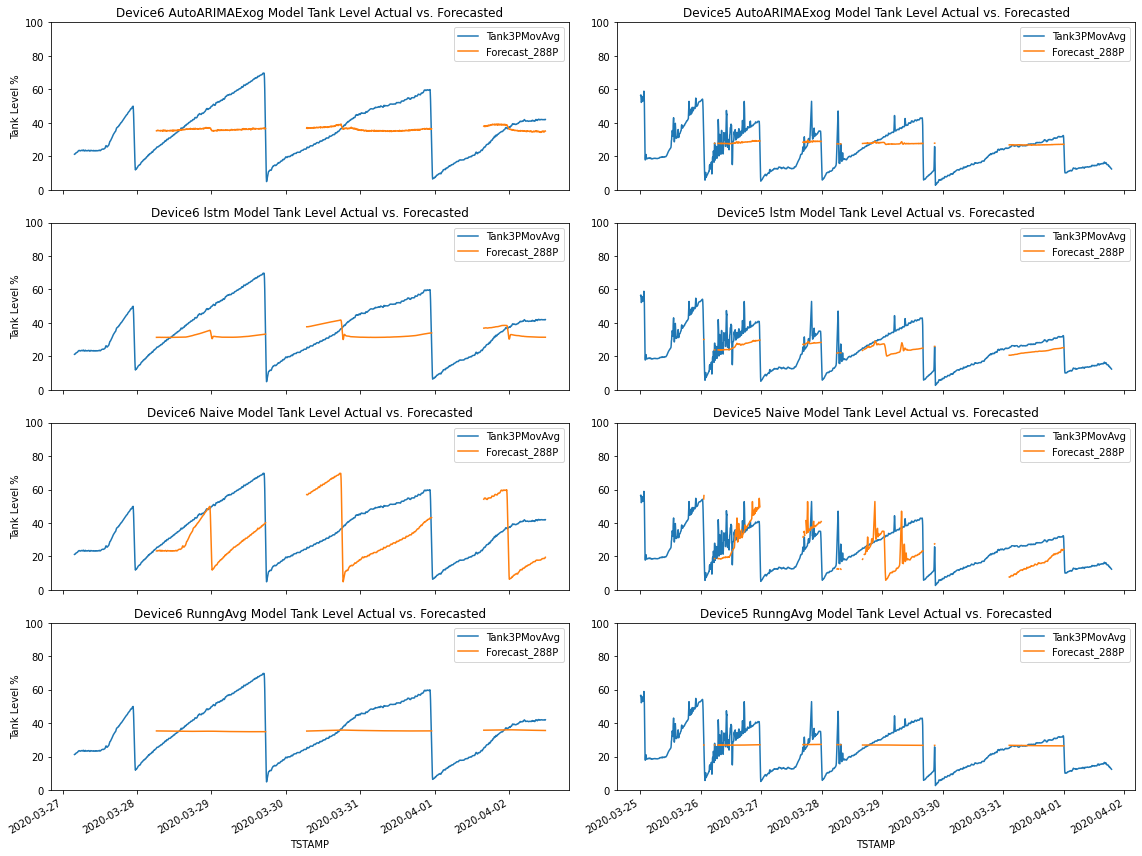

In [54]:
# plot tank levels for each device within the test range
%matplotlib inline

idealmod = "AutoARIMAExog"
allmod = "lstm"
naivemod = "Naive"
avgmod = "RunngAvg"

# get dfs from forecast file
device_ids = [6,5]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16,12))
# fig.suptitle(f'Device Tank Levels During Forecast Test Timeframes', size = 20, y=1.02)


df1 = forecastcsv_to_dfs(file='data/AutoARIMAExog_model_forecasts_alldevices.csv', device_ids=device_ids)
df2 = forecastcsv_to_dfs(file='data/lstm_model_forecasts_alldevices.csv', device_ids=device_ids)
df3 = forecastcsv_to_dfs(file='data/Naive_model_forecasts_alldevices.csv', device_ids=device_ids)
df4 = forecastcsv_to_dfs(file='data/RunningAvg_model_forecasts_alldevices.csv', device_ids=device_ids)

# top ideal
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df1[6][threshhold_col] < flt_thrsh
filt_threshAll = df1[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df1[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df1[5].loc[filt_threshAll, forecast_cols] = np.nan

df1[6][actual_cols + forecast_cols].plot(ax=axs[0][0],
                                         title = f'Device6 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df1[5][actual_cols + forecast_cols].plot(ax=axs[0][1],
                                         title = f'Device5 {idealmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# top all
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df2[6][threshhold_col] < flt_thrsh
filt_threshAll = df2[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df2[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df2[5].loc[filt_threshAll, forecast_cols] = np.nan

df2[6][actual_cols + forecast_cols].plot(ax=axs[1][0],
                                         title = f'Device6 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df2[5][actual_cols + forecast_cols].plot(ax=axs[1][1],
                                         title = f'Device5 {allmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# naive
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df3[6][threshhold_col] < flt_thrsh
filt_threshAll = df3[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df3[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df3[5].loc[filt_threshAll, forecast_cols] = np.nan

df3[6][actual_cols + forecast_cols].plot(ax=axs[2][0],
                                         title = f'Device6 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df3[5][actual_cols + forecast_cols].plot(ax=axs[2][1],
                                         title = f'Device5 {naivemod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


# Avg
# create a series that is a boolean filter of actual values less than threshold
filt_threshIdeal = df4[6][threshhold_col] < flt_thrsh
filt_threshAll = df4[5][threshhold_col] < flt_thrsh
# set forecast values to nan where the actual value is less than threshold
df4[6].loc[filt_threshIdeal, forecast_cols] = np.nan
df4[5].loc[filt_threshAll, forecast_cols] = np.nan

df4[6][actual_cols + forecast_cols].plot(ax=axs[3][0],
                                         title = f'Device6 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 

df4[5][actual_cols + forecast_cols].plot(ax=axs[3][1],
                                         title = f'Device5 {avgmod} Model Tank Level Actual vs. Forecasted',
                                         ylim=(0,100) ) 


axs[0][0].set_ylabel('Tank Level %')
axs[1][0].set_ylabel('Tank Level %')
axs[2][0].set_ylabel('Tank Level %')
axs[3][0].set_ylabel('Tank Level %')
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')
axs[2][1].set_ylabel('')
axs[3][1].set_ylabel('')

axs[0][0].set_xlabel('')
axs[0][1].set_xlabel('')
axs[1][0].set_xlabel('')
axs[1][1].set_xlabel('')
axs[2][0].set_xlabel('')
axs[2][1].set_xlabel('')

axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[1][0].set_xticklabels([])
axs[1][1].set_xticklabels([])
axs[2][0].set_xticklabels([])
axs[2][1].set_xticklabels([])


plt.tight_layout()

fig.savefig('figures/288Pforecastplots.png')